In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from tqdm import tqdm_notebook

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# default parameters
batch_size = 64  # input batch size
image_size = 64  # height / width of input image to network
nz = 100 # size of latent z vector
ngf = 32
ndf = 32
lr = 0.0002 # learning rate
beta1 = 0.5 # beta1 for adam
outf = 'output_images'
workers = 2
ngpu = 1
nc = 3 # number of channels
netG_weights = '' # pre-defined model for generator
netD_weights = '' # pre-defined model for discriminator

In [4]:
if not os.path.exists(outf):
    os.makedirs(outf)

In [5]:
path_to_data = '/efs/data/CIFAR'
%time dataset = dset.CIFAR10(root=path_to_data, download=True, \
                            transform=transforms.Compose([ \
                            transforms.Scale(image_size), \
                            transforms.ToTensor(), \
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) \
                        ]))
%time raw_dataset = dset.CIFAR10(root=path_to_data, download=False)

Files already downloaded and verified
CPU times: user 804 ms, sys: 300 ms, total: 1.1 s
Wall time: 1.19 s
CPU times: user 460 ms, sys: 240 ms, total: 700 ms
Wall time: 746 ms


In [6]:
%time cat_idx = [i for i, img in enumerate(dataset) if img[1] == 3]
%time cat_dataset = [dataset[i] for i in cat_idx]
%time cat_raw_dataset = [raw_dataset[i] for i in cat_idx]

CPU times: user 11.8 s, sys: 40 ms, total: 11.8 s
Wall time: 11.8 s
CPU times: user 1.23 s, sys: 28 ms, total: 1.26 s
Wall time: 1.26 s
CPU times: user 244 ms, sys: 8 ms, total: 252 ms
Wall time: 247 ms


In [7]:
dataloader = torch.utils.data.DataLoader(cat_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [8]:
# cust weights initialization called on generator and discriminator networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
# generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution                                                                                                                                                                               
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4                                                                                                                                                                                        
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8                                                                                                                                                                                        
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16                                                                                                                                                                                      
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32                                                                                                                                                                                        
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32                                                                                                                                                                                                                    
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [10]:
# discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64                                                                                                                                                                                            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32                                                                                                                                                                                        
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16                                                                                                                                                                                      
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8                                                                                                                                                                                        
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4                                                                                                                                                                                        
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [11]:
netG = _netG(ngpu)
netG.apply(weights_init)
if netG_weights != '':
    netG.load_state_dict(torch.load(netG_weights))
print(netG)

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)


In [12]:
netD = _netD(ngpu)
netD.apply(weights_init)
if netD_weights != '':
    netD.load_state_dict(torch.load(netD_weights))
print(netD)

_netD (
  (main): Sequential (
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid ()
  )
)


In [13]:
criterion = nn.BCELoss()

In [14]:
# define tensors
input = torch.FloatTensor(batch_size, 3, image_size, image_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = Variable(torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1))
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [15]:
# switch to cuda if on GPU
if torch.cuda.is_available():
    print('cuda enabled')
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

cuda enabled


In [16]:
# setup optimizer                                                                                                                                                                                                                                 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [17]:
# test sample
test_dataloader = torch.utils.data.DataLoader(cat_dataset, batch_size=1,
                                              shuffle=False, num_workers=1)
test_data_iter = iter(test_dataloader)
img_id = 9
for _ in range(img_id+1):
    test_sample = next(test_data_iter)

In [18]:
def Unnormalize(img):
    return ((img*0.5+0.5)*255).astype(np.uint8) # using 0.5 for mean and std (as from Normalize call above)

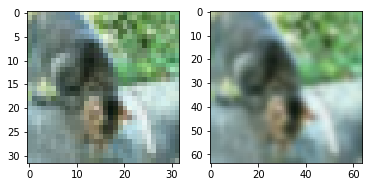

In [19]:
# plot original raw image against normalized image
plt.figure()
plt.subplot(121)
plt.imshow(np.asarray(cat_raw_dataset[img_id][0]))
plt.subplot(122)
plt.imshow(Unnormalize(test_sample[0].numpy()[0].transpose(1,2,0)))

In [20]:
# single pass though networks
netD.zero_grad()
real_cpu, _ = test_sample
batch_size = real_cpu.size(0)
if torch.cuda.is_available():
    real_cpu = real_cpu.cuda()
input.resize_as_(real_cpu).copy_(real_cpu)
label.resize_(batch_size).fill_(real_label)
inputv = Variable(input)
labelv = Variable(label)

In [21]:
output = netD(inputv)
errD_real = criterion(output, labelv)
errD_real.backward()
D_x = output.data.mean()

In [22]:
print(fixed_noise.size())
fake = netG(fixed_noise)
print(fake.size())

torch.Size([64, 100, 1, 1])
torch.Size([64, 3, 64, 64])


In [24]:
niter = 100
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################                                                                                                                                                                                                              
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        # train with real                                                                                                                                                                                                                         
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake                                                                                                                                                                                                                         
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################                                                                                                                                                                                                              
        # (2) Update G network: maximize log(D(G(z)))                                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost                                                                                                                                                     
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing                                                                                                                                                                                                                            
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/100][0/79] Loss_D: 1.2400 Loss_G: 2.3826 D(x): 0.5558 D(G(z)): 0.4281 / 0.1078
[0/100][1/79] Loss_D: 1.0151 Loss_G: 2.5034 D(x): 0.6331 D(G(z)): 0.3873 / 0.0965
[0/100][2/79] Loss_D: 0.9211 Loss_G: 2.6503 D(x): 0.6682 D(G(z)): 0.3677 / 0.0823
[0/100][3/79] Loss_D: 0.9828 Loss_G: 2.7911 D(x): 0.6482 D(G(z)): 0.3584 / 0.0758
[0/100][4/79] Loss_D: 0.8242 Loss_G: 3.0881 D(x): 0.7253 D(G(z)): 0.3400 / 0.0585
[0/100][5/79] Loss_D: 0.7355 Loss_G: 3.2603 D(x): 0.7489 D(G(z)): 0.3240 / 0.0461
[0/100][6/79] Loss_D: 0.6802 Loss_G: 3.3645 D(x): 0.7386 D(G(z)): 0.2743 / 0.0439
[0/100][7/79] Loss_D: 0.6635 Loss_G: 3.4567 D(x): 0.7845 D(G(z)): 0.3060 / 0.0375
[0/100][8/79] Loss_D: 0.6130 Loss_G: 3.7517 D(x): 0.8095 D(G(z)): 0.3026 / 0.0280
[0/100][9/79] Loss_D: 0.6027 Loss_G: 3.8959 D(x): 0.7882 D(G(z)): 0.2640 / 0.0248
[0/100][10/79] Loss_D: 0.7131 Loss_G: 3.7880 D(x): 0.7217 D(G(z)): 0.2702 / 0.0267
[0/100][11/79] Loss_D: 0.5839 Loss_G: 3.9380 D(x): 0.7579 D(G(z)): 0.2144 / 0.0230
[0/100][12/79]

[1/100][22/79] Loss_D: 0.0238 Loss_G: 6.9300 D(x): 0.9911 D(G(z)): 0.0147 / 0.0011
[1/100][23/79] Loss_D: 0.0797 Loss_G: 6.2827 D(x): 0.9508 D(G(z)): 0.0265 / 0.0021
[1/100][24/79] Loss_D: 0.0582 Loss_G: 7.9744 D(x): 0.9866 D(G(z)): 0.0433 / 0.0004
[1/100][25/79] Loss_D: 0.0252 Loss_G: 7.6960 D(x): 0.9815 D(G(z)): 0.0056 / 0.0006
[1/100][26/79] Loss_D: 0.0249 Loss_G: 6.3832 D(x): 0.9859 D(G(z)): 0.0104 / 0.0021
[1/100][27/79] Loss_D: 0.0526 Loss_G: 6.9797 D(x): 0.9868 D(G(z)): 0.0377 / 0.0012
[1/100][28/79] Loss_D: 0.0266 Loss_G: 7.0498 D(x): 0.9869 D(G(z)): 0.0129 / 0.0011
[1/100][29/79] Loss_D: 0.0354 Loss_G: 6.5408 D(x): 0.9842 D(G(z)): 0.0187 / 0.0018
[1/100][30/79] Loss_D: 0.0608 Loss_G: 6.2292 D(x): 0.9678 D(G(z)): 0.0238 / 0.0024
[1/100][31/79] Loss_D: 0.0571 Loss_G: 7.5583 D(x): 0.9838 D(G(z)): 0.0390 / 0.0007
[1/100][32/79] Loss_D: 0.0418 Loss_G: 6.9572 D(x): 0.9722 D(G(z)): 0.0121 / 0.0012
[1/100][33/79] Loss_D: 0.0346 Loss_G: 6.9507 D(x): 0.9908 D(G(z)): 0.0248 / 0.0013
[1/1

[2/100][43/79] Loss_D: 0.3815 Loss_G: 5.6264 D(x): 0.7401 D(G(z)): 0.0042 / 0.0050
[2/100][44/79] Loss_D: 0.1499 Loss_G: 4.0669 D(x): 0.9489 D(G(z)): 0.0764 / 0.0231
[2/100][45/79] Loss_D: 0.5894 Loss_G: 9.7463 D(x): 0.9666 D(G(z)): 0.3854 / 0.0001
[2/100][46/79] Loss_D: 0.9326 Loss_G: 6.7270 D(x): 0.5279 D(G(z)): 0.0013 / 0.0025
[2/100][47/79] Loss_D: 0.1014 Loss_G: 4.0259 D(x): 0.9487 D(G(z)): 0.0405 / 0.0321
[2/100][48/79] Loss_D: 0.3338 Loss_G: 6.1866 D(x): 0.9701 D(G(z)): 0.2277 / 0.0033
[2/100][49/79] Loss_D: 0.1424 Loss_G: 5.9345 D(x): 0.9358 D(G(z)): 0.0536 / 0.0040
[2/100][50/79] Loss_D: 0.2554 Loss_G: 4.6277 D(x): 0.8844 D(G(z)): 0.0732 / 0.0141
[2/100][51/79] Loss_D: 0.3668 Loss_G: 7.3931 D(x): 0.9350 D(G(z)): 0.2291 / 0.0011
[2/100][52/79] Loss_D: 0.6287 Loss_G: 2.7555 D(x): 0.6500 D(G(z)): 0.0162 / 0.0922
[2/100][53/79] Loss_D: 1.2603 Loss_G: 11.4340 D(x): 0.9815 D(G(z)): 0.6597 / 0.0000
[2/100][54/79] Loss_D: 1.7094 Loss_G: 9.1020 D(x): 0.3442 D(G(z)): 0.0002 / 0.0002
[2/

[3/100][64/79] Loss_D: 0.1533 Loss_G: 5.0525 D(x): 0.8907 D(G(z)): 0.0049 / 0.0086
[3/100][65/79] Loss_D: 0.1462 Loss_G: 8.1328 D(x): 0.9957 D(G(z)): 0.1270 / 0.0004
[3/100][66/79] Loss_D: 0.0118 Loss_G: 8.6529 D(x): 0.9929 D(G(z)): 0.0045 / 0.0002
[3/100][67/79] Loss_D: 0.0114 Loss_G: 7.6438 D(x): 0.9919 D(G(z)): 0.0030 / 0.0007
[3/100][68/79] Loss_D: 0.0187 Loss_G: 6.1863 D(x): 0.9904 D(G(z)): 0.0089 / 0.0030
[3/100][69/79] Loss_D: 0.0618 Loss_G: 5.9505 D(x): 0.9824 D(G(z)): 0.0418 / 0.0035
[3/100][70/79] Loss_D: 0.0533 Loss_G: 6.7294 D(x): 0.9882 D(G(z)): 0.0397 / 0.0017
[3/100][71/79] Loss_D: 0.0768 Loss_G: 6.4456 D(x): 0.9696 D(G(z)): 0.0270 / 0.0020
[3/100][72/79] Loss_D: 0.0387 Loss_G: 6.3902 D(x): 0.9852 D(G(z)): 0.0216 / 0.0021
[3/100][73/79] Loss_D: 0.0647 Loss_G: 6.6390 D(x): 0.9756 D(G(z)): 0.0369 / 0.0016
[3/100][74/79] Loss_D: 0.0525 Loss_G: 6.7212 D(x): 0.9761 D(G(z)): 0.0263 / 0.0015
[3/100][75/79] Loss_D: 0.0494 Loss_G: 6.3593 D(x): 0.9721 D(G(z)): 0.0195 / 0.0021
[3/1

[5/100][7/79] Loss_D: 0.2605 Loss_G: 5.6678 D(x): 0.8952 D(G(z)): 0.0008 / 0.0042
[5/100][8/79] Loss_D: 0.1417 Loss_G: 5.5248 D(x): 0.9560 D(G(z)): 0.0781 / 0.0051
[5/100][9/79] Loss_D: 0.0922 Loss_G: 8.9830 D(x): 0.9970 D(G(z)): 0.0829 / 0.0002
[5/100][10/79] Loss_D: 0.0200 Loss_G: 9.5083 D(x): 0.9837 D(G(z)): 0.0014 / 0.0001
[5/100][11/79] Loss_D: 0.0478 Loss_G: 7.5867 D(x): 0.9655 D(G(z)): 0.0013 / 0.0007
[5/100][12/79] Loss_D: 0.0473 Loss_G: 5.3512 D(x): 0.9702 D(G(z)): 0.0076 / 0.0064
[5/100][13/79] Loss_D: 0.0829 Loss_G: 7.5670 D(x): 0.9899 D(G(z)): 0.0689 / 0.0006
[5/100][14/79] Loss_D: 0.1366 Loss_G: 6.1559 D(x): 0.9175 D(G(z)): 0.0063 / 0.0025
[5/100][15/79] Loss_D: 0.0332 Loss_G: 5.8493 D(x): 0.9893 D(G(z)): 0.0203 / 0.0033
[5/100][16/79] Loss_D: 0.0528 Loss_G: 7.5120 D(x): 0.9914 D(G(z)): 0.0425 / 0.0006
[5/100][17/79] Loss_D: 0.0747 Loss_G: 6.3572 D(x): 0.9549 D(G(z)): 0.0083 / 0.0020
[5/100][18/79] Loss_D: 0.0473 Loss_G: 6.7850 D(x): 0.9859 D(G(z)): 0.0305 / 0.0013
[5/100]

[6/100][28/79] Loss_D: 0.1603 Loss_G: 4.0724 D(x): 0.9148 D(G(z)): 0.0483 / 0.0247
[6/100][29/79] Loss_D: 0.1697 Loss_G: 4.5465 D(x): 0.9402 D(G(z)): 0.0778 / 0.0145
[6/100][30/79] Loss_D: 0.1197 Loss_G: 5.2316 D(x): 0.9570 D(G(z)): 0.0660 / 0.0068
[6/100][31/79] Loss_D: 0.1409 Loss_G: 4.5939 D(x): 0.9265 D(G(z)): 0.0274 / 0.0134
[6/100][32/79] Loss_D: 0.1292 Loss_G: 4.9558 D(x): 0.9639 D(G(z)): 0.0804 / 0.0100
[6/100][33/79] Loss_D: 0.2746 Loss_G: 3.5257 D(x): 0.8598 D(G(z)): 0.0480 / 0.0401
[6/100][34/79] Loss_D: 0.2832 Loss_G: 5.5992 D(x): 0.9272 D(G(z)): 0.1592 / 0.0054
[6/100][35/79] Loss_D: 0.1987 Loss_G: 4.4788 D(x): 0.8941 D(G(z)): 0.0329 / 0.0149
[6/100][36/79] Loss_D: 0.1376 Loss_G: 5.1551 D(x): 0.9742 D(G(z)): 0.1009 / 0.0076
[6/100][37/79] Loss_D: 0.2135 Loss_G: 4.1730 D(x): 0.8824 D(G(z)): 0.0510 / 0.0232
[6/100][38/79] Loss_D: 0.1748 Loss_G: 5.5725 D(x): 0.9638 D(G(z)): 0.1215 / 0.0049
[6/100][39/79] Loss_D: 0.2122 Loss_G: 4.0052 D(x): 0.8859 D(G(z)): 0.0435 / 0.0308
[6/1

[7/100][49/79] Loss_D: 0.8019 Loss_G: 4.2047 D(x): 0.7835 D(G(z)): 0.3763 / 0.0192
[7/100][50/79] Loss_D: 1.2777 Loss_G: 0.9934 D(x): 0.4278 D(G(z)): 0.1243 / 0.4416
[7/100][51/79] Loss_D: 2.0129 Loss_G: 8.5408 D(x): 0.8802 D(G(z)): 0.7903 / 0.0004
[7/100][52/79] Loss_D: 3.5400 Loss_G: 2.5093 D(x): 0.0606 D(G(z)): 0.0021 / 0.1389
[7/100][53/79] Loss_D: 0.5648 Loss_G: 1.8385 D(x): 0.8119 D(G(z)): 0.2391 / 0.2401
[7/100][54/79] Loss_D: 0.6113 Loss_G: 3.6758 D(x): 0.9135 D(G(z)): 0.3496 / 0.0424
[7/100][55/79] Loss_D: 0.6806 Loss_G: 1.7763 D(x): 0.6157 D(G(z)): 0.1143 / 0.2061
[7/100][56/79] Loss_D: 0.6571 Loss_G: 3.4268 D(x): 0.9233 D(G(z)): 0.3868 / 0.0458
[7/100][57/79] Loss_D: 0.4876 Loss_G: 2.6175 D(x): 0.7342 D(G(z)): 0.1000 / 0.1002
[7/100][58/79] Loss_D: 0.5428 Loss_G: 2.4549 D(x): 0.8232 D(G(z)): 0.2571 / 0.1050
[7/100][59/79] Loss_D: 0.8522 Loss_G: 3.2311 D(x): 0.7851 D(G(z)): 0.3884 / 0.0598
[7/100][60/79] Loss_D: 1.1842 Loss_G: 0.7927 D(x): 0.4624 D(G(z)): 0.1606 / 0.4976
[7/1

[8/100][70/79] Loss_D: 0.5407 Loss_G: 2.8302 D(x): 0.6888 D(G(z)): 0.0895 / 0.0927
[8/100][71/79] Loss_D: 0.4764 Loss_G: 3.4473 D(x): 0.8599 D(G(z)): 0.2520 / 0.0451
[8/100][72/79] Loss_D: 0.7367 Loss_G: 3.4984 D(x): 0.7138 D(G(z)): 0.2584 / 0.0506
[8/100][73/79] Loss_D: 0.6889 Loss_G: 3.2471 D(x): 0.7185 D(G(z)): 0.2304 / 0.0674
[8/100][74/79] Loss_D: 0.7171 Loss_G: 3.3401 D(x): 0.7205 D(G(z)): 0.2603 / 0.0525
[8/100][75/79] Loss_D: 0.4345 Loss_G: 4.2038 D(x): 0.8524 D(G(z)): 0.2051 / 0.0221
[8/100][76/79] Loss_D: 0.4164 Loss_G: 3.6786 D(x): 0.7932 D(G(z)): 0.1012 / 0.0382
[8/100][77/79] Loss_D: 0.3838 Loss_G: 2.4144 D(x): 0.7947 D(G(z)): 0.1097 / 0.1137
[8/100][78/79] Loss_D: 0.4434 Loss_G: 5.9271 D(x): 0.9757 D(G(z)): 0.3177 / 0.0030
[9/100][0/79] Loss_D: 0.5450 Loss_G: 2.1644 D(x): 0.6589 D(G(z)): 0.0221 / 0.1724
[9/100][1/79] Loss_D: 0.6736 Loss_G: 5.8264 D(x): 0.9128 D(G(z)): 0.3910 / 0.0042
[9/100][2/79] Loss_D: 0.5768 Loss_G: 4.0879 D(x): 0.6383 D(G(z)): 0.0139 / 0.0287
[9/100]

[10/100][13/79] Loss_D: 0.2309 Loss_G: 3.3494 D(x): 0.8498 D(G(z)): 0.0449 / 0.0461
[10/100][14/79] Loss_D: 0.2971 Loss_G: 3.8334 D(x): 0.9437 D(G(z)): 0.1992 / 0.0272
[10/100][15/79] Loss_D: 0.2737 Loss_G: 3.4746 D(x): 0.8235 D(G(z)): 0.0533 / 0.0399
[10/100][16/79] Loss_D: 0.2564 Loss_G: 3.0535 D(x): 0.8963 D(G(z)): 0.1239 / 0.0642
[10/100][17/79] Loss_D: 0.3795 Loss_G: 3.6536 D(x): 0.8985 D(G(z)): 0.2113 / 0.0387
[10/100][18/79] Loss_D: 0.3656 Loss_G: 3.7551 D(x): 0.8251 D(G(z)): 0.1312 / 0.0315
[10/100][19/79] Loss_D: 0.4522 Loss_G: 2.3572 D(x): 0.7555 D(G(z)): 0.1041 / 0.1133
[10/100][20/79] Loss_D: 0.5717 Loss_G: 3.0095 D(x): 0.9151 D(G(z)): 0.3519 / 0.0771
[10/100][21/79] Loss_D: 0.6428 Loss_G: 4.2403 D(x): 0.7332 D(G(z)): 0.2274 / 0.0267
[10/100][22/79] Loss_D: 0.3887 Loss_G: 3.1175 D(x): 0.7768 D(G(z)): 0.0848 / 0.0681
[10/100][23/79] Loss_D: 0.4515 Loss_G: 5.2206 D(x): 0.8418 D(G(z)): 0.2122 / 0.0072
[10/100][24/79] Loss_D: 0.3347 Loss_G: 3.1842 D(x): 0.7779 D(G(z)): 0.0347 /

[11/100][34/79] Loss_D: 1.0304 Loss_G: 1.2612 D(x): 0.4561 D(G(z)): 0.0463 / 0.3536
[11/100][35/79] Loss_D: 1.1479 Loss_G: 3.2879 D(x): 0.8018 D(G(z)): 0.5327 / 0.0647
[11/100][36/79] Loss_D: 1.0962 Loss_G: 1.5126 D(x): 0.4766 D(G(z)): 0.1139 / 0.2497
[11/100][37/79] Loss_D: 0.7609 Loss_G: 2.9847 D(x): 0.8964 D(G(z)): 0.4431 / 0.0662
[11/100][38/79] Loss_D: 0.5305 Loss_G: 2.7996 D(x): 0.7470 D(G(z)): 0.1748 / 0.0828
[11/100][39/79] Loss_D: 0.5571 Loss_G: 2.4600 D(x): 0.7633 D(G(z)): 0.2098 / 0.1064
[11/100][40/79] Loss_D: 0.7286 Loss_G: 3.3459 D(x): 0.8178 D(G(z)): 0.3674 / 0.0454
[11/100][41/79] Loss_D: 0.9601 Loss_G: 1.4009 D(x): 0.5217 D(G(z)): 0.1239 / 0.2947
[11/100][42/79] Loss_D: 0.9316 Loss_G: 4.8598 D(x): 0.9302 D(G(z)): 0.5259 / 0.0102
[11/100][43/79] Loss_D: 1.2057 Loss_G: 2.1744 D(x): 0.3691 D(G(z)): 0.0296 / 0.1342
[11/100][44/79] Loss_D: 0.5129 Loss_G: 2.3767 D(x): 0.8837 D(G(z)): 0.3022 / 0.1152
[11/100][45/79] Loss_D: 0.5415 Loss_G: 3.9078 D(x): 0.8879 D(G(z)): 0.3102 /

[12/100][55/79] Loss_D: 0.5968 Loss_G: 2.9784 D(x): 0.8848 D(G(z)): 0.3134 / 0.0858
[12/100][56/79] Loss_D: 0.4947 Loss_G: 4.0654 D(x): 0.8560 D(G(z)): 0.2361 / 0.0340
[12/100][57/79] Loss_D: 0.5817 Loss_G: 1.5351 D(x): 0.6772 D(G(z)): 0.0992 / 0.2546
[12/100][58/79] Loss_D: 0.9935 Loss_G: 4.6938 D(x): 0.9456 D(G(z)): 0.5351 / 0.0174
[12/100][59/79] Loss_D: 0.8184 Loss_G: 2.5422 D(x): 0.5311 D(G(z)): 0.0616 / 0.1439
[12/100][60/79] Loss_D: 0.6728 Loss_G: 2.2455 D(x): 0.7841 D(G(z)): 0.2944 / 0.1370
[12/100][61/79] Loss_D: 0.3725 Loss_G: 3.8979 D(x): 0.9078 D(G(z)): 0.2178 / 0.0311
[12/100][62/79] Loss_D: 0.4042 Loss_G: 3.2052 D(x): 0.8097 D(G(z)): 0.1411 / 0.0609
[12/100][63/79] Loss_D: 0.5186 Loss_G: 2.3451 D(x): 0.7773 D(G(z)): 0.1650 / 0.1416
[12/100][64/79] Loss_D: 0.5453 Loss_G: 4.3754 D(x): 0.9122 D(G(z)): 0.3160 / 0.0204
[12/100][65/79] Loss_D: 0.6087 Loss_G: 1.7118 D(x): 0.6388 D(G(z)): 0.0746 / 0.2373
[12/100][66/79] Loss_D: 0.6373 Loss_G: 4.6055 D(x): 0.8943 D(G(z)): 0.3658 /

[13/100][76/79] Loss_D: 0.4313 Loss_G: 4.4866 D(x): 0.8750 D(G(z)): 0.2235 / 0.0187
[13/100][77/79] Loss_D: 0.3121 Loss_G: 3.5361 D(x): 0.8021 D(G(z)): 0.0578 / 0.0396
[13/100][78/79] Loss_D: 0.2871 Loss_G: 2.0487 D(x): 0.8261 D(G(z)): 0.0820 / 0.1509
[14/100][0/79] Loss_D: 1.2038 Loss_G: 6.8050 D(x): 0.9634 D(G(z)): 0.6252 / 0.0021
[14/100][1/79] Loss_D: 0.6435 Loss_G: 4.9364 D(x): 0.6093 D(G(z)): 0.0091 / 0.0153
[14/100][2/79] Loss_D: 0.4691 Loss_G: 2.1475 D(x): 0.7130 D(G(z)): 0.0348 / 0.1694
[14/100][3/79] Loss_D: 0.6252 Loss_G: 3.9804 D(x): 0.9454 D(G(z)): 0.3724 / 0.0316
[14/100][4/79] Loss_D: 0.4348 Loss_G: 3.5197 D(x): 0.7743 D(G(z)): 0.1246 / 0.0449
[14/100][5/79] Loss_D: 0.5827 Loss_G: 2.9241 D(x): 0.7680 D(G(z)): 0.1999 / 0.0775
[14/100][6/79] Loss_D: 0.6243 Loss_G: 3.0162 D(x): 0.7648 D(G(z)): 0.2485 / 0.0686
[14/100][7/79] Loss_D: 0.5992 Loss_G: 3.8000 D(x): 0.8092 D(G(z)): 0.2799 / 0.0359
[14/100][8/79] Loss_D: 0.4524 Loss_G: 3.8699 D(x): 0.8104 D(G(z)): 0.1704 / 0.0339
[

[15/100][16/79] Loss_D: 0.2792 Loss_G: 3.8649 D(x): 0.9161 D(G(z)): 0.1578 / 0.0342
[15/100][17/79] Loss_D: 0.2373 Loss_G: 4.3106 D(x): 0.9039 D(G(z)): 0.1112 / 0.0220
[15/100][18/79] Loss_D: 0.4593 Loss_G: 4.4710 D(x): 0.8390 D(G(z)): 0.2074 / 0.0185
[15/100][19/79] Loss_D: 0.1850 Loss_G: 4.6408 D(x): 0.8966 D(G(z)): 0.0622 / 0.0161
[15/100][20/79] Loss_D: 0.3907 Loss_G: 3.8620 D(x): 0.8422 D(G(z)): 0.1559 / 0.0331
[15/100][21/79] Loss_D: 0.7259 Loss_G: 2.0363 D(x): 0.6445 D(G(z)): 0.1128 / 0.1898
[15/100][22/79] Loss_D: 0.8799 Loss_G: 5.8091 D(x): 0.9334 D(G(z)): 0.4880 / 0.0048
[15/100][23/79] Loss_D: 0.7583 Loss_G: 4.2836 D(x): 0.5640 D(G(z)): 0.0322 / 0.0375
[15/100][24/79] Loss_D: 0.4029 Loss_G: 3.5536 D(x): 0.8793 D(G(z)): 0.1765 / 0.0688
[15/100][25/79] Loss_D: 0.3936 Loss_G: 4.3164 D(x): 0.8941 D(G(z)): 0.1868 / 0.0306
[15/100][26/79] Loss_D: 0.3652 Loss_G: 4.1062 D(x): 0.8675 D(G(z)): 0.1479 / 0.0305
[15/100][27/79] Loss_D: 0.3887 Loss_G: 3.8518 D(x): 0.8444 D(G(z)): 0.1336 /

[16/100][37/79] Loss_D: 0.6604 Loss_G: 1.8378 D(x): 0.8147 D(G(z)): 0.3158 / 0.2071
[16/100][38/79] Loss_D: 0.6807 Loss_G: 3.3320 D(x): 0.8456 D(G(z)): 0.3598 / 0.0477
[16/100][39/79] Loss_D: 0.4677 Loss_G: 3.2442 D(x): 0.7640 D(G(z)): 0.1386 / 0.0559
[16/100][40/79] Loss_D: 0.7348 Loss_G: 2.4998 D(x): 0.7414 D(G(z)): 0.3085 / 0.1064
[16/100][41/79] Loss_D: 0.5789 Loss_G: 2.9791 D(x): 0.7825 D(G(z)): 0.2408 / 0.0727
[16/100][42/79] Loss_D: 0.7372 Loss_G: 3.1622 D(x): 0.7679 D(G(z)): 0.3240 / 0.0541
[16/100][43/79] Loss_D: 0.3683 Loss_G: 3.2443 D(x): 0.8356 D(G(z)): 0.1379 / 0.0538
[16/100][44/79] Loss_D: 0.5041 Loss_G: 3.6299 D(x): 0.8552 D(G(z)): 0.2546 / 0.0372
[16/100][45/79] Loss_D: 0.4414 Loss_G: 2.1181 D(x): 0.7298 D(G(z)): 0.0680 / 0.1400
[16/100][46/79] Loss_D: 0.4854 Loss_G: 4.5485 D(x): 0.9457 D(G(z)): 0.3222 / 0.0139
[16/100][47/79] Loss_D: 0.6042 Loss_G: 1.9177 D(x): 0.6391 D(G(z)): 0.0607 / 0.1835
[16/100][48/79] Loss_D: 0.5835 Loss_G: 4.7100 D(x): 0.9646 D(G(z)): 0.3909 /

[17/100][58/79] Loss_D: 1.1962 Loss_G: 2.1388 D(x): 0.3944 D(G(z)): 0.0108 / 0.1787
[17/100][59/79] Loss_D: 0.5988 Loss_G: 3.1100 D(x): 0.9037 D(G(z)): 0.3499 / 0.0592
[17/100][60/79] Loss_D: 0.4435 Loss_G: 4.6743 D(x): 0.8672 D(G(z)): 0.2364 / 0.0124
[17/100][61/79] Loss_D: 0.4575 Loss_G: 3.1150 D(x): 0.7192 D(G(z)): 0.0478 / 0.0659
[17/100][62/79] Loss_D: 0.3222 Loss_G: 3.8514 D(x): 0.9502 D(G(z)): 0.2258 / 0.0269
[17/100][63/79] Loss_D: 0.6747 Loss_G: 1.9996 D(x): 0.6300 D(G(z)): 0.0951 / 0.1641
[17/100][64/79] Loss_D: 0.4975 Loss_G: 3.2453 D(x): 0.8900 D(G(z)): 0.2927 / 0.0516
[17/100][65/79] Loss_D: 0.2546 Loss_G: 3.9579 D(x): 0.9277 D(G(z)): 0.1514 / 0.0271
[17/100][66/79] Loss_D: 0.5047 Loss_G: 2.7919 D(x): 0.6961 D(G(z)): 0.0833 / 0.0895
[17/100][67/79] Loss_D: 0.3807 Loss_G: 3.0572 D(x): 0.8948 D(G(z)): 0.2015 / 0.0628
[17/100][68/79] Loss_D: 0.3781 Loss_G: 2.6976 D(x): 0.7956 D(G(z)): 0.1152 / 0.0810
[17/100][69/79] Loss_D: 0.3984 Loss_G: 3.4968 D(x): 0.9060 D(G(z)): 0.2376 /

[19/100][0/79] Loss_D: 0.4680 Loss_G: 4.4762 D(x): 0.8460 D(G(z)): 0.2277 / 0.0169
[19/100][1/79] Loss_D: 0.4855 Loss_G: 3.7871 D(x): 0.7738 D(G(z)): 0.1665 / 0.0312
[19/100][2/79] Loss_D: 0.4565 Loss_G: 6.0303 D(x): 0.9176 D(G(z)): 0.2814 / 0.0039
[19/100][3/79] Loss_D: 0.2457 Loss_G: 4.7866 D(x): 0.8312 D(G(z)): 0.0399 / 0.0138
[19/100][4/79] Loss_D: 0.4063 Loss_G: 3.5795 D(x): 0.8458 D(G(z)): 0.1770 / 0.0434
[19/100][5/79] Loss_D: 0.7572 Loss_G: 4.9688 D(x): 0.7755 D(G(z)): 0.3444 / 0.0093
[19/100][6/79] Loss_D: 0.6223 Loss_G: 3.7698 D(x): 0.7183 D(G(z)): 0.2043 / 0.0340
[19/100][7/79] Loss_D: 0.4475 Loss_G: 2.7390 D(x): 0.7931 D(G(z)): 0.1496 / 0.0863
[19/100][8/79] Loss_D: 0.8067 Loss_G: 5.3426 D(x): 0.8077 D(G(z)): 0.3885 / 0.0070
[19/100][9/79] Loss_D: 0.8631 Loss_G: 1.2047 D(x): 0.5054 D(G(z)): 0.0451 / 0.3428
[19/100][10/79] Loss_D: 1.1296 Loss_G: 7.3485 D(x): 0.9628 D(G(z)): 0.6158 / 0.0012
[19/100][11/79] Loss_D: 1.1579 Loss_G: 4.8157 D(x): 0.4063 D(G(z)): 0.0040 / 0.0179
[1

[20/100][19/79] Loss_D: 0.5431 Loss_G: 2.4634 D(x): 0.7193 D(G(z)): 0.1340 / 0.1215
[20/100][20/79] Loss_D: 0.7694 Loss_G: 5.0418 D(x): 0.8584 D(G(z)): 0.4098 / 0.0091
[20/100][21/79] Loss_D: 0.7245 Loss_G: 2.2203 D(x): 0.6009 D(G(z)): 0.0978 / 0.1387
[20/100][22/79] Loss_D: 1.2391 Loss_G: 1.8030 D(x): 0.5113 D(G(z)): 0.3384 / 0.2085
[20/100][23/79] Loss_D: 0.9900 Loss_G: 5.9582 D(x): 0.8618 D(G(z)): 0.5028 / 0.0036
[20/100][24/79] Loss_D: 1.3081 Loss_G: 0.6167 D(x): 0.3404 D(G(z)): 0.0158 / 0.5801
[20/100][25/79] Loss_D: 2.1095 Loss_G: 7.6114 D(x): 0.9757 D(G(z)): 0.8228 / 0.0009
[20/100][26/79] Loss_D: 1.2375 Loss_G: 4.9398 D(x): 0.3730 D(G(z)): 0.0040 / 0.0158
[20/100][27/79] Loss_D: 0.6063 Loss_G: 1.7521 D(x): 0.6550 D(G(z)): 0.0638 / 0.2434
[20/100][28/79] Loss_D: 1.0724 Loss_G: 4.5960 D(x): 0.9895 D(G(z)): 0.5726 / 0.0165
[20/100][29/79] Loss_D: 0.2753 Loss_G: 4.8456 D(x): 0.8434 D(G(z)): 0.0721 / 0.0135
[20/100][30/79] Loss_D: 0.8628 Loss_G: 1.6718 D(x): 0.5564 D(G(z)): 0.0372 /

[21/100][40/79] Loss_D: 0.4812 Loss_G: 3.8151 D(x): 0.8903 D(G(z)): 0.2554 / 0.0349
[21/100][41/79] Loss_D: 0.4732 Loss_G: 2.9463 D(x): 0.7200 D(G(z)): 0.1037 / 0.0832
[21/100][42/79] Loss_D: 0.5266 Loss_G: 1.5088 D(x): 0.7030 D(G(z)): 0.1137 / 0.2782
[21/100][43/79] Loss_D: 0.8353 Loss_G: 4.6305 D(x): 0.9285 D(G(z)): 0.4719 / 0.0140
[21/100][44/79] Loss_D: 0.8679 Loss_G: 1.7535 D(x): 0.4992 D(G(z)): 0.0531 / 0.2362
[21/100][45/79] Loss_D: 0.7241 Loss_G: 2.5784 D(x): 0.8716 D(G(z)): 0.3774 / 0.1176
[21/100][46/79] Loss_D: 0.6058 Loss_G: 2.6530 D(x): 0.7272 D(G(z)): 0.1889 / 0.1063
[21/100][47/79] Loss_D: 1.0146 Loss_G: 1.4860 D(x): 0.6201 D(G(z)): 0.3016 / 0.2838
[21/100][48/79] Loss_D: 0.8008 Loss_G: 4.0689 D(x): 0.8769 D(G(z)): 0.4255 / 0.0259
[21/100][49/79] Loss_D: 0.3717 Loss_G: 3.9233 D(x): 0.8115 D(G(z)): 0.1325 / 0.0287
[21/100][50/79] Loss_D: 1.2907 Loss_G: 0.8894 D(x): 0.3616 D(G(z)): 0.1021 / 0.4627
[21/100][51/79] Loss_D: 1.2002 Loss_G: 3.2423 D(x): 0.9540 D(G(z)): 0.6242 /

[22/100][61/79] Loss_D: 0.5929 Loss_G: 2.3504 D(x): 0.6701 D(G(z)): 0.1176 / 0.1333
[22/100][62/79] Loss_D: 0.5863 Loss_G: 4.1759 D(x): 0.8702 D(G(z)): 0.3208 / 0.0218
[22/100][63/79] Loss_D: 0.2818 Loss_G: 3.8279 D(x): 0.8316 D(G(z)): 0.0731 / 0.0332
[22/100][64/79] Loss_D: 0.3839 Loss_G: 3.9265 D(x): 0.8207 D(G(z)): 0.1434 / 0.0283
[22/100][65/79] Loss_D: 0.2136 Loss_G: 3.9848 D(x): 0.9170 D(G(z)): 0.1074 / 0.0275
[22/100][66/79] Loss_D: 0.1759 Loss_G: 4.4391 D(x): 0.9590 D(G(z)): 0.1191 / 0.0167
[22/100][67/79] Loss_D: 0.2036 Loss_G: 4.0913 D(x): 0.8911 D(G(z)): 0.0751 / 0.0281
[22/100][68/79] Loss_D: 0.3066 Loss_G: 3.1097 D(x): 0.8247 D(G(z)): 0.0919 / 0.0631
[22/100][69/79] Loss_D: 0.5024 Loss_G: 5.8373 D(x): 0.9388 D(G(z)): 0.3239 / 0.0042
[22/100][70/79] Loss_D: 0.3411 Loss_G: 4.8242 D(x): 0.7444 D(G(z)): 0.0165 / 0.0121
[22/100][71/79] Loss_D: 0.2754 Loss_G: 2.9455 D(x): 0.8405 D(G(z)): 0.0823 / 0.0753
[22/100][72/79] Loss_D: 0.6343 Loss_G: 5.4164 D(x): 0.8562 D(G(z)): 0.3496 /

[24/100][1/79] Loss_D: 0.9406 Loss_G: 3.9766 D(x): 0.9257 D(G(z)): 0.5324 / 0.0240
[24/100][2/79] Loss_D: 0.5936 Loss_G: 2.9903 D(x): 0.6312 D(G(z)): 0.0682 / 0.0810
[24/100][3/79] Loss_D: 0.6707 Loss_G: 3.4536 D(x): 0.8631 D(G(z)): 0.3669 / 0.0426
[24/100][4/79] Loss_D: 0.5037 Loss_G: 2.9203 D(x): 0.7381 D(G(z)): 0.1425 / 0.0771
[24/100][5/79] Loss_D: 0.5740 Loss_G: 3.6625 D(x): 0.8801 D(G(z)): 0.3282 / 0.0351
[24/100][6/79] Loss_D: 0.5076 Loss_G: 3.7386 D(x): 0.8125 D(G(z)): 0.2256 / 0.0351
[24/100][7/79] Loss_D: 0.9103 Loss_G: 3.0938 D(x): 0.6346 D(G(z)): 0.3026 / 0.0630
[24/100][8/79] Loss_D: 1.3413 Loss_G: 1.7055 D(x): 0.4385 D(G(z)): 0.2693 / 0.2223
[24/100][9/79] Loss_D: 1.1349 Loss_G: 6.4721 D(x): 0.8887 D(G(z)): 0.5926 / 0.0029
[24/100][10/79] Loss_D: 0.7546 Loss_G: 4.4421 D(x): 0.5600 D(G(z)): 0.0236 / 0.0244
[24/100][11/79] Loss_D: 0.3705 Loss_G: 3.3794 D(x): 0.8611 D(G(z)): 0.1671 / 0.0547
[24/100][12/79] Loss_D: 0.3218 Loss_G: 4.2546 D(x): 0.9166 D(G(z)): 0.1857 / 0.0266
[

[25/100][22/79] Loss_D: 0.4750 Loss_G: 5.7081 D(x): 0.9637 D(G(z)): 0.3345 / 0.0044
[25/100][23/79] Loss_D: 0.5784 Loss_G: 1.7205 D(x): 0.6191 D(G(z)): 0.0362 / 0.2119
[25/100][24/79] Loss_D: 0.5530 Loss_G: 6.3347 D(x): 0.9679 D(G(z)): 0.3864 / 0.0027
[25/100][25/79] Loss_D: 0.6658 Loss_G: 3.5790 D(x): 0.5748 D(G(z)): 0.0056 / 0.0562
[25/100][26/79] Loss_D: 0.3717 Loss_G: 4.1441 D(x): 0.9786 D(G(z)): 0.2655 / 0.0206
[25/100][27/79] Loss_D: 0.5474 Loss_G: 2.1105 D(x): 0.6716 D(G(z)): 0.0656 / 0.1622
[25/100][28/79] Loss_D: 0.9842 Loss_G: 6.2703 D(x): 0.9726 D(G(z)): 0.5509 / 0.0029
[25/100][29/79] Loss_D: 0.4179 Loss_G: 6.0371 D(x): 0.6890 D(G(z)): 0.0071 / 0.0047
[25/100][30/79] Loss_D: 0.5699 Loss_G: 2.0422 D(x): 0.6281 D(G(z)): 0.0123 / 0.1805
[25/100][31/79] Loss_D: 0.6268 Loss_G: 3.4710 D(x): 0.9455 D(G(z)): 0.3980 / 0.0408
[25/100][32/79] Loss_D: 0.5430 Loss_G: 2.3406 D(x): 0.6626 D(G(z)): 0.0803 / 0.1206
[25/100][33/79] Loss_D: 0.7950 Loss_G: 5.7910 D(x): 0.9747 D(G(z)): 0.5030 /

[26/100][43/79] Loss_D: 0.9640 Loss_G: 5.3427 D(x): 0.9198 D(G(z)): 0.5320 / 0.0073
[26/100][44/79] Loss_D: 2.5344 Loss_G: 2.2918 D(x): 0.1504 D(G(z)): 0.0080 / 0.1510
[26/100][45/79] Loss_D: 0.5184 Loss_G: 2.5587 D(x): 0.9183 D(G(z)): 0.3061 / 0.1128
[26/100][46/79] Loss_D: 0.6960 Loss_G: 5.1502 D(x): 0.9465 D(G(z)): 0.4263 / 0.0104
[26/100][47/79] Loss_D: 1.1502 Loss_G: 1.8503 D(x): 0.4430 D(G(z)): 0.0355 / 0.1943
[26/100][48/79] Loss_D: 0.6311 Loss_G: 1.9318 D(x): 0.8000 D(G(z)): 0.2959 / 0.1910
[26/100][49/79] Loss_D: 1.0912 Loss_G: 4.3421 D(x): 0.8309 D(G(z)): 0.5133 / 0.0193
[26/100][50/79] Loss_D: 1.4530 Loss_G: 1.4816 D(x): 0.3615 D(G(z)): 0.1533 / 0.2984
[26/100][51/79] Loss_D: 1.5968 Loss_G: 4.2171 D(x): 0.8346 D(G(z)): 0.6880 / 0.0253
[26/100][52/79] Loss_D: 0.8171 Loss_G: 3.3850 D(x): 0.5907 D(G(z)): 0.1483 / 0.0546
[26/100][53/79] Loss_D: 0.4946 Loss_G: 2.7721 D(x): 0.7787 D(G(z)): 0.1737 / 0.0950
[26/100][54/79] Loss_D: 0.5356 Loss_G: 3.6124 D(x): 0.8833 D(G(z)): 0.2790 /

[27/100][64/79] Loss_D: 0.7738 Loss_G: 3.4075 D(x): 0.8467 D(G(z)): 0.4028 / 0.0433
[27/100][65/79] Loss_D: 0.3743 Loss_G: 3.2997 D(x): 0.7914 D(G(z)): 0.0984 / 0.0597
[27/100][66/79] Loss_D: 0.3325 Loss_G: 2.5652 D(x): 0.8092 D(G(z)): 0.0891 / 0.0953
[27/100][67/79] Loss_D: 0.5873 Loss_G: 3.0064 D(x): 0.8479 D(G(z)): 0.3038 / 0.0676
[27/100][68/79] Loss_D: 0.6122 Loss_G: 1.9369 D(x): 0.6732 D(G(z)): 0.1511 / 0.1657
[27/100][69/79] Loss_D: 0.4987 Loss_G: 3.1316 D(x): 0.9242 D(G(z)): 0.3051 / 0.0610
[27/100][70/79] Loss_D: 0.6553 Loss_G: 2.4837 D(x): 0.7095 D(G(z)): 0.2057 / 0.1149
[27/100][71/79] Loss_D: 0.4003 Loss_G: 2.3464 D(x): 0.7892 D(G(z)): 0.1282 / 0.1200
[27/100][72/79] Loss_D: 0.4397 Loss_G: 2.9215 D(x): 0.8890 D(G(z)): 0.2484 / 0.0758
[27/100][73/79] Loss_D: 0.8184 Loss_G: 2.7384 D(x): 0.7145 D(G(z)): 0.3117 / 0.0848
[27/100][74/79] Loss_D: 0.7003 Loss_G: 1.7294 D(x): 0.6185 D(G(z)): 0.1462 / 0.2213
[27/100][75/79] Loss_D: 0.6533 Loss_G: 2.4824 D(x): 0.8065 D(G(z)): 0.3044 /

[29/100][4/79] Loss_D: 0.4748 Loss_G: 3.5534 D(x): 0.7853 D(G(z)): 0.1763 / 0.0438
[29/100][5/79] Loss_D: 0.3687 Loss_G: 2.4034 D(x): 0.7770 D(G(z)): 0.0906 / 0.1232
[29/100][6/79] Loss_D: 0.7067 Loss_G: 4.3571 D(x): 0.9010 D(G(z)): 0.4105 / 0.0181
[29/100][7/79] Loss_D: 0.6297 Loss_G: 2.8300 D(x): 0.6081 D(G(z)): 0.0400 / 0.0797
[29/100][8/79] Loss_D: 0.3675 Loss_G: 2.3816 D(x): 0.8580 D(G(z)): 0.1771 / 0.1101
[29/100][9/79] Loss_D: 0.3653 Loss_G: 3.7376 D(x): 0.9147 D(G(z)): 0.2199 / 0.0321
[29/100][10/79] Loss_D: 0.3020 Loss_G: 3.5832 D(x): 0.8769 D(G(z)): 0.1425 / 0.0374
[29/100][11/79] Loss_D: 0.3517 Loss_G: 2.8014 D(x): 0.8239 D(G(z)): 0.1239 / 0.0812
[29/100][12/79] Loss_D: 0.4963 Loss_G: 3.9897 D(x): 0.8988 D(G(z)): 0.2916 / 0.0280
[29/100][13/79] Loss_D: 0.8434 Loss_G: 1.4732 D(x): 0.5377 D(G(z)): 0.0885 / 0.2742
[29/100][14/79] Loss_D: 0.9066 Loss_G: 5.3342 D(x): 0.9183 D(G(z)): 0.5134 / 0.0067
[29/100][15/79] Loss_D: 0.7083 Loss_G: 3.2473 D(x): 0.5691 D(G(z)): 0.0475 / 0.065

[30/100][25/79] Loss_D: 0.6056 Loss_G: 1.8743 D(x): 0.6503 D(G(z)): 0.1121 / 0.2085
[30/100][26/79] Loss_D: 0.6853 Loss_G: 3.6705 D(x): 0.9326 D(G(z)): 0.4026 / 0.0385
[30/100][27/79] Loss_D: 0.6325 Loss_G: 2.1599 D(x): 0.6577 D(G(z)): 0.1258 / 0.1540
[30/100][28/79] Loss_D: 0.7222 Loss_G: 2.0231 D(x): 0.7236 D(G(z)): 0.2821 / 0.1641
[30/100][29/79] Loss_D: 0.6779 Loss_G: 2.7136 D(x): 0.7533 D(G(z)): 0.2944 / 0.0847
[30/100][30/79] Loss_D: 0.6165 Loss_G: 2.1642 D(x): 0.7038 D(G(z)): 0.1897 / 0.1430
[30/100][31/79] Loss_D: 0.4918 Loss_G: 3.1054 D(x): 0.8854 D(G(z)): 0.2894 / 0.0562
[30/100][32/79] Loss_D: 0.5200 Loss_G: 2.5243 D(x): 0.7762 D(G(z)): 0.2013 / 0.0989
[30/100][33/79] Loss_D: 0.7025 Loss_G: 1.7364 D(x): 0.6693 D(G(z)): 0.2014 / 0.2166
[30/100][34/79] Loss_D: 0.5992 Loss_G: 2.8793 D(x): 0.8331 D(G(z)): 0.3067 / 0.0741
[30/100][35/79] Loss_D: 0.4164 Loss_G: 2.4334 D(x): 0.7616 D(G(z)): 0.1052 / 0.1177
[30/100][36/79] Loss_D: 0.5084 Loss_G: 3.0211 D(x): 0.8806 D(G(z)): 0.2907 /

[31/100][46/79] Loss_D: 2.0763 Loss_G: 1.5877 D(x): 0.1889 D(G(z)): 0.0236 / 0.2568
[31/100][47/79] Loss_D: 0.7263 Loss_G: 2.1535 D(x): 0.7974 D(G(z)): 0.3477 / 0.1386
[31/100][48/79] Loss_D: 0.6911 Loss_G: 5.6103 D(x): 0.8724 D(G(z)): 0.3796 / 0.0051
[31/100][49/79] Loss_D: 2.1740 Loss_G: 0.0325 D(x): 0.1555 D(G(z)): 0.0203 / 0.9688
[31/100][50/79] Loss_D: 4.4336 Loss_G: 1.9260 D(x): 0.9853 D(G(z)): 0.9806 / 0.2020
[31/100][51/79] Loss_D: 1.5095 Loss_G: 1.5895 D(x): 0.3525 D(G(z)): 0.2137 / 0.2453
[31/100][52/79] Loss_D: 1.0687 Loss_G: 1.2852 D(x): 0.6041 D(G(z)): 0.3554 / 0.3247
[31/100][53/79] Loss_D: 1.2783 Loss_G: 1.3932 D(x): 0.6023 D(G(z)): 0.4535 / 0.2822
[31/100][54/79] Loss_D: 1.1764 Loss_G: 2.2523 D(x): 0.6944 D(G(z)): 0.4955 / 0.1332
[31/100][55/79] Loss_D: 0.7958 Loss_G: 1.7836 D(x): 0.5978 D(G(z)): 0.1888 / 0.1873
[31/100][56/79] Loss_D: 0.9826 Loss_G: 1.3386 D(x): 0.6187 D(G(z)): 0.3495 / 0.2971
[31/100][57/79] Loss_D: 1.3131 Loss_G: 3.2886 D(x): 0.8342 D(G(z)): 0.6165 /

[32/100][67/79] Loss_D: 0.1656 Loss_G: 4.3417 D(x): 0.9607 D(G(z)): 0.1101 / 0.0225
[32/100][68/79] Loss_D: 0.1854 Loss_G: 3.7463 D(x): 0.8939 D(G(z)): 0.0626 / 0.0335
[32/100][69/79] Loss_D: 0.1967 Loss_G: 3.2645 D(x): 0.8721 D(G(z)): 0.0491 / 0.0559
[32/100][70/79] Loss_D: 0.2183 Loss_G: 3.0341 D(x): 0.9016 D(G(z)): 0.0913 / 0.0666
[32/100][71/79] Loss_D: 0.3215 Loss_G: 3.1710 D(x): 0.9096 D(G(z)): 0.1809 / 0.0547
[32/100][72/79] Loss_D: 0.1573 Loss_G: 3.6475 D(x): 0.9056 D(G(z)): 0.0510 / 0.0340
[32/100][73/79] Loss_D: 0.2799 Loss_G: 2.9997 D(x): 0.8956 D(G(z)): 0.1464 / 0.0639
[32/100][74/79] Loss_D: 0.7471 Loss_G: 0.9041 D(x): 0.5773 D(G(z)): 0.0735 / 0.4371
[32/100][75/79] Loss_D: 0.8256 Loss_G: 4.5033 D(x): 0.9634 D(G(z)): 0.5102 / 0.0146
[32/100][76/79] Loss_D: 0.2089 Loss_G: 3.8190 D(x): 0.8778 D(G(z)): 0.0651 / 0.0327
[32/100][77/79] Loss_D: 0.4564 Loss_G: 1.6791 D(x): 0.6880 D(G(z)): 0.0342 / 0.2542
[32/100][78/79] Loss_D: 0.6310 Loss_G: 4.7201 D(x): 0.8587 D(G(z)): 0.3411 /

[34/100][7/79] Loss_D: 0.9012 Loss_G: 2.4588 D(x): 0.7284 D(G(z)): 0.3736 / 0.1108
[34/100][8/79] Loss_D: 0.5734 Loss_G: 2.8050 D(x): 0.8008 D(G(z)): 0.2531 / 0.0842
[34/100][9/79] Loss_D: 0.4690 Loss_G: 2.8489 D(x): 0.7932 D(G(z)): 0.1798 / 0.0768
[34/100][10/79] Loss_D: 0.3590 Loss_G: 2.4885 D(x): 0.8068 D(G(z)): 0.1133 / 0.1044
[34/100][11/79] Loss_D: 0.8406 Loss_G: 2.1584 D(x): 0.6782 D(G(z)): 0.3013 / 0.1473
[34/100][12/79] Loss_D: 0.8855 Loss_G: 4.9292 D(x): 0.8486 D(G(z)): 0.4678 / 0.0104
[34/100][13/79] Loss_D: 2.2079 Loss_G: 0.7008 D(x): 0.1468 D(G(z)): 0.0316 / 0.5374
[34/100][14/79] Loss_D: 1.3052 Loss_G: 2.6566 D(x): 0.8849 D(G(z)): 0.6433 / 0.0863
[34/100][15/79] Loss_D: 0.5342 Loss_G: 3.5067 D(x): 0.8046 D(G(z)): 0.2405 / 0.0376
[34/100][16/79] Loss_D: 0.2461 Loss_G: 3.4580 D(x): 0.8709 D(G(z)): 0.0955 / 0.0424
[34/100][17/79] Loss_D: 0.7252 Loss_G: 1.6684 D(x): 0.6108 D(G(z)): 0.1335 / 0.2296
[34/100][18/79] Loss_D: 0.8117 Loss_G: 3.1650 D(x): 0.8951 D(G(z)): 0.4597 / 0.

[35/100][28/79] Loss_D: 0.3355 Loss_G: 2.7600 D(x): 0.8364 D(G(z)): 0.1243 / 0.0854
[35/100][29/79] Loss_D: 0.4776 Loss_G: 2.4673 D(x): 0.8148 D(G(z)): 0.2147 / 0.1045
[35/100][30/79] Loss_D: 0.2694 Loss_G: 3.2587 D(x): 0.8869 D(G(z)): 0.1265 / 0.0505
[35/100][31/79] Loss_D: 0.3373 Loss_G: 3.1800 D(x): 0.8815 D(G(z)): 0.1774 / 0.0554
[35/100][32/79] Loss_D: 0.4193 Loss_G: 2.4177 D(x): 0.7445 D(G(z)): 0.0964 / 0.1160
[35/100][33/79] Loss_D: 0.5545 Loss_G: 2.9646 D(x): 0.8697 D(G(z)): 0.3153 / 0.0642
[35/100][34/79] Loss_D: 0.5914 Loss_G: 3.2353 D(x): 0.7930 D(G(z)): 0.2713 / 0.0520
[35/100][35/79] Loss_D: 0.7574 Loss_G: 1.6203 D(x): 0.5848 D(G(z)): 0.1297 / 0.2375
[35/100][36/79] Loss_D: 1.0555 Loss_G: 2.9846 D(x): 0.7323 D(G(z)): 0.4634 / 0.0668
[35/100][37/79] Loss_D: 0.3365 Loss_G: 2.8201 D(x): 0.8070 D(G(z)): 0.0982 / 0.0808
[35/100][38/79] Loss_D: 0.5826 Loss_G: 1.9232 D(x): 0.7232 D(G(z)): 0.1858 / 0.1794
[35/100][39/79] Loss_D: 0.4858 Loss_G: 3.3981 D(x): 0.9330 D(G(z)): 0.3185 /

[36/100][49/79] Loss_D: 0.3914 Loss_G: 2.7758 D(x): 0.7146 D(G(z)): 0.0302 / 0.0820
[36/100][50/79] Loss_D: 0.4904 Loss_G: 3.0636 D(x): 0.8464 D(G(z)): 0.2447 / 0.0641
[36/100][51/79] Loss_D: 0.2623 Loss_G: 3.1942 D(x): 0.8599 D(G(z)): 0.0956 / 0.0533
[36/100][52/79] Loss_D: 0.4748 Loss_G: 3.1231 D(x): 0.8073 D(G(z)): 0.2041 / 0.0592
[36/100][53/79] Loss_D: 0.6754 Loss_G: 1.5434 D(x): 0.6333 D(G(z)): 0.1529 / 0.2477
[36/100][54/79] Loss_D: 0.8283 Loss_G: 3.5350 D(x): 0.8457 D(G(z)): 0.4221 / 0.0423
[36/100][55/79] Loss_D: 0.8411 Loss_G: 0.8337 D(x): 0.5437 D(G(z)): 0.1327 / 0.4709
[36/100][56/79] Loss_D: 0.8965 Loss_G: 2.8354 D(x): 0.9375 D(G(z)): 0.5330 / 0.0713
[36/100][57/79] Loss_D: 0.6218 Loss_G: 1.1841 D(x): 0.6782 D(G(z)): 0.1618 / 0.3366
[36/100][58/79] Loss_D: 0.8443 Loss_G: 6.9520 D(x): 0.9106 D(G(z)): 0.4943 / 0.0016
[36/100][59/79] Loss_D: 3.0700 Loss_G: 1.3494 D(x): 0.0902 D(G(z)): 0.0040 / 0.3227
[36/100][60/79] Loss_D: 0.7162 Loss_G: 3.2789 D(x): 0.9432 D(G(z)): 0.4436 /

[37/100][70/79] Loss_D: 0.4776 Loss_G: 3.0904 D(x): 0.8581 D(G(z)): 0.2480 / 0.0616
[37/100][71/79] Loss_D: 0.2897 Loss_G: 3.0107 D(x): 0.8313 D(G(z)): 0.0850 / 0.0671
[37/100][72/79] Loss_D: 0.2417 Loss_G: 2.7752 D(x): 0.8830 D(G(z)): 0.1017 / 0.0804
[37/100][73/79] Loss_D: 0.3174 Loss_G: 3.2268 D(x): 0.9155 D(G(z)): 0.1921 / 0.0518
[37/100][74/79] Loss_D: 0.2206 Loss_G: 3.3961 D(x): 0.9016 D(G(z)): 0.1018 / 0.0435
[37/100][75/79] Loss_D: 0.4342 Loss_G: 2.3474 D(x): 0.7791 D(G(z)): 0.1388 / 0.1193
[37/100][76/79] Loss_D: 0.3377 Loss_G: 2.7418 D(x): 0.8868 D(G(z)): 0.1796 / 0.0828
[37/100][77/79] Loss_D: 0.4333 Loss_G: 2.8703 D(x): 0.8391 D(G(z)): 0.2071 / 0.0711
[37/100][78/79] Loss_D: 0.7955 Loss_G: 2.2713 D(x): 0.6201 D(G(z)): 0.2553 / 0.1102
[38/100][0/79] Loss_D: 0.4543 Loss_G: 3.5540 D(x): 0.9218 D(G(z)): 0.2823 / 0.0423
[38/100][1/79] Loss_D: 0.4847 Loss_G: 2.4758 D(x): 0.7356 D(G(z)): 0.1246 / 0.1069
[38/100][2/79] Loss_D: 0.5272 Loss_G: 3.0063 D(x): 0.8399 D(G(z)): 0.2627 / 0.

[39/100][10/79] Loss_D: 0.9635 Loss_G: 1.8476 D(x): 0.6447 D(G(z)): 0.3448 / 0.1857
[39/100][11/79] Loss_D: 0.7552 Loss_G: 3.4567 D(x): 0.8859 D(G(z)): 0.4080 / 0.0470
[39/100][12/79] Loss_D: 0.8196 Loss_G: 2.4101 D(x): 0.6407 D(G(z)): 0.2411 / 0.1259
[39/100][13/79] Loss_D: 0.7601 Loss_G: 3.1744 D(x): 0.7349 D(G(z)): 0.3071 / 0.0618
[39/100][14/79] Loss_D: 0.6233 Loss_G: 2.6727 D(x): 0.7118 D(G(z)): 0.2029 / 0.0919
[39/100][15/79] Loss_D: 0.8390 Loss_G: 1.8344 D(x): 0.6222 D(G(z)): 0.2091 / 0.2023
[39/100][16/79] Loss_D: 0.5184 Loss_G: 3.2379 D(x): 0.8769 D(G(z)): 0.2903 / 0.0497
[39/100][17/79] Loss_D: 0.3354 Loss_G: 3.5616 D(x): 0.8754 D(G(z)): 0.1616 / 0.0371
[39/100][18/79] Loss_D: 0.5361 Loss_G: 2.4454 D(x): 0.7018 D(G(z)): 0.1159 / 0.1062
[39/100][19/79] Loss_D: 0.4429 Loss_G: 2.5549 D(x): 0.8284 D(G(z)): 0.1934 / 0.1059
[39/100][20/79] Loss_D: 0.3787 Loss_G: 2.9307 D(x): 0.8604 D(G(z)): 0.1847 / 0.0677
[39/100][21/79] Loss_D: 0.3225 Loss_G: 3.3574 D(x): 0.9056 D(G(z)): 0.1812 /

[40/100][31/79] Loss_D: 0.3768 Loss_G: 2.9048 D(x): 0.8843 D(G(z)): 0.2099 / 0.0655
[40/100][32/79] Loss_D: 0.5570 Loss_G: 2.2762 D(x): 0.7168 D(G(z)): 0.1758 / 0.1202
[40/100][33/79] Loss_D: 0.5781 Loss_G: 3.7681 D(x): 0.9141 D(G(z)): 0.3537 / 0.0312
[40/100][34/79] Loss_D: 0.6340 Loss_G: 2.3105 D(x): 0.6051 D(G(z)): 0.0702 / 0.1364
[40/100][35/79] Loss_D: 0.6610 Loss_G: 2.8351 D(x): 0.8537 D(G(z)): 0.3593 / 0.0762
[40/100][36/79] Loss_D: 0.6443 Loss_G: 1.6994 D(x): 0.6371 D(G(z)): 0.1248 / 0.2135
[40/100][37/79] Loss_D: 0.5883 Loss_G: 3.8151 D(x): 0.9583 D(G(z)): 0.3982 / 0.0284
[40/100][38/79] Loss_D: 0.5303 Loss_G: 2.3553 D(x): 0.6604 D(G(z)): 0.0620 / 0.1238
[40/100][39/79] Loss_D: 0.2313 Loss_G: 3.0613 D(x): 0.9540 D(G(z)): 0.1610 / 0.0593
[40/100][40/79] Loss_D: 0.2903 Loss_G: 3.2247 D(x): 0.8872 D(G(z)): 0.1457 / 0.0519
[40/100][41/79] Loss_D: 0.4299 Loss_G: 3.1088 D(x): 0.8424 D(G(z)): 0.2103 / 0.0574
[40/100][42/79] Loss_D: 0.4125 Loss_G: 2.3732 D(x): 0.7502 D(G(z)): 0.0949 /

[41/100][52/79] Loss_D: 0.4261 Loss_G: 3.2791 D(x): 0.9289 D(G(z)): 0.2781 / 0.0498
[41/100][53/79] Loss_D: 0.2581 Loss_G: 4.2597 D(x): 0.9256 D(G(z)): 0.1527 / 0.0215
[41/100][54/79] Loss_D: 0.5275 Loss_G: 2.2530 D(x): 0.6981 D(G(z)): 0.1032 / 0.1414
[41/100][55/79] Loss_D: 0.3453 Loss_G: 3.8729 D(x): 0.9389 D(G(z)): 0.2218 / 0.0308
[41/100][56/79] Loss_D: 0.3473 Loss_G: 3.8486 D(x): 0.8729 D(G(z)): 0.1716 / 0.0280
[41/100][57/79] Loss_D: 0.4465 Loss_G: 2.2676 D(x): 0.7025 D(G(z)): 0.0441 / 0.1434
[41/100][58/79] Loss_D: 0.6513 Loss_G: 3.8215 D(x): 0.8762 D(G(z)): 0.3634 / 0.0301
[41/100][59/79] Loss_D: 0.4983 Loss_G: 2.6338 D(x): 0.7199 D(G(z)): 0.1161 / 0.1041
[41/100][60/79] Loss_D: 0.5201 Loss_G: 2.8957 D(x): 0.8282 D(G(z)): 0.2487 / 0.0788
[41/100][61/79] Loss_D: 0.6304 Loss_G: 4.4413 D(x): 0.8440 D(G(z)): 0.3240 / 0.0169
[41/100][62/79] Loss_D: 1.2339 Loss_G: 0.7039 D(x): 0.3536 D(G(z)): 0.0377 / 0.5383
[41/100][63/79] Loss_D: 1.2021 Loss_G: 5.2068 D(x): 0.9778 D(G(z)): 0.6440 /

[42/100][73/79] Loss_D: 0.2577 Loss_G: 3.7960 D(x): 0.9516 D(G(z)): 0.1726 / 0.0342
[42/100][74/79] Loss_D: 0.4152 Loss_G: 2.9971 D(x): 0.7393 D(G(z)): 0.0623 / 0.0697
[42/100][75/79] Loss_D: 0.4595 Loss_G: 2.1931 D(x): 0.8102 D(G(z)): 0.1906 / 0.1444
[42/100][76/79] Loss_D: 0.7054 Loss_G: 1.9151 D(x): 0.6955 D(G(z)): 0.2414 / 0.1934
[42/100][77/79] Loss_D: 0.9424 Loss_G: 4.0802 D(x): 0.8757 D(G(z)): 0.4924 / 0.0275
[42/100][78/79] Loss_D: 0.3067 Loss_G: 4.8534 D(x): 0.7627 D(G(z)): 0.0148 / 0.0109
[43/100][0/79] Loss_D: 0.3379 Loss_G: 3.0287 D(x): 0.8441 D(G(z)): 0.1320 / 0.0773
[43/100][1/79] Loss_D: 0.5389 Loss_G: 2.7805 D(x): 0.7852 D(G(z)): 0.2232 / 0.0823
[43/100][2/79] Loss_D: 0.2367 Loss_G: 3.6317 D(x): 0.9485 D(G(z)): 0.1573 / 0.0353
[43/100][3/79] Loss_D: 0.2839 Loss_G: 3.6770 D(x): 0.9030 D(G(z)): 0.1546 / 0.0335
[43/100][4/79] Loss_D: 0.1584 Loss_G: 4.0737 D(x): 0.9002 D(G(z)): 0.0447 / 0.0239
[43/100][5/79] Loss_D: 0.3956 Loss_G: 2.5520 D(x): 0.7743 D(G(z)): 0.1080 / 0.098

[44/100][13/79] Loss_D: 0.5677 Loss_G: 2.9026 D(x): 0.8307 D(G(z)): 0.2832 / 0.0731
[44/100][14/79] Loss_D: 0.4018 Loss_G: 2.7427 D(x): 0.7955 D(G(z)): 0.1346 / 0.0806
[44/100][15/79] Loss_D: 0.3177 Loss_G: 3.2146 D(x): 0.9087 D(G(z)): 0.1821 / 0.0554
[44/100][16/79] Loss_D: 0.4754 Loss_G: 2.4882 D(x): 0.7570 D(G(z)): 0.1476 / 0.1047
[44/100][17/79] Loss_D: 0.4058 Loss_G: 2.2568 D(x): 0.7853 D(G(z)): 0.1162 / 0.1337
[44/100][18/79] Loss_D: 0.5862 Loss_G: 4.1764 D(x): 0.9636 D(G(z)): 0.3877 / 0.0207
[44/100][19/79] Loss_D: 0.6839 Loss_G: 2.5428 D(x): 0.5820 D(G(z)): 0.0574 / 0.1001
[44/100][20/79] Loss_D: 0.3435 Loss_G: 2.5853 D(x): 0.8795 D(G(z)): 0.1795 / 0.0971
[44/100][21/79] Loss_D: 0.4276 Loss_G: 3.4648 D(x): 0.8800 D(G(z)): 0.2362 / 0.0396
[44/100][22/79] Loss_D: 0.4651 Loss_G: 2.1380 D(x): 0.7104 D(G(z)): 0.0813 / 0.1418
[44/100][23/79] Loss_D: 0.5009 Loss_G: 3.2729 D(x): 0.8884 D(G(z)): 0.2933 / 0.0444
[44/100][24/79] Loss_D: 0.3289 Loss_G: 3.9906 D(x): 0.9028 D(G(z)): 0.1882 /

[45/100][34/79] Loss_D: 0.3631 Loss_G: 3.9405 D(x): 0.9690 D(G(z)): 0.2555 / 0.0262
[45/100][35/79] Loss_D: 0.3461 Loss_G: 2.9034 D(x): 0.8002 D(G(z)): 0.0979 / 0.0707
[45/100][36/79] Loss_D: 0.2902 Loss_G: 2.4691 D(x): 0.8655 D(G(z)): 0.1235 / 0.1046
[45/100][37/79] Loss_D: 0.2767 Loss_G: 3.4915 D(x): 0.9565 D(G(z)): 0.1801 / 0.0473
[45/100][38/79] Loss_D: 0.2922 Loss_G: 2.6950 D(x): 0.8340 D(G(z)): 0.0857 / 0.0898
[45/100][39/79] Loss_D: 0.3081 Loss_G: 2.6115 D(x): 0.8885 D(G(z)): 0.1571 / 0.0948
[45/100][40/79] Loss_D: 0.3641 Loss_G: 2.6363 D(x): 0.8396 D(G(z)): 0.1533 / 0.0876
[45/100][41/79] Loss_D: 0.3872 Loss_G: 3.7523 D(x): 0.8942 D(G(z)): 0.2147 / 0.0331
[45/100][42/79] Loss_D: 0.3534 Loss_G: 2.5138 D(x): 0.7628 D(G(z)): 0.0550 / 0.1136
[45/100][43/79] Loss_D: 0.3194 Loss_G: 3.2607 D(x): 0.9252 D(G(z)): 0.2010 / 0.0514
[45/100][44/79] Loss_D: 0.2970 Loss_G: 2.9065 D(x): 0.8078 D(G(z)): 0.0669 / 0.0709
[45/100][45/79] Loss_D: 0.3061 Loss_G: 3.1628 D(x): 0.9303 D(G(z)): 0.1945 /

[46/100][55/79] Loss_D: 0.4792 Loss_G: 2.0941 D(x): 0.7181 D(G(z)): 0.1070 / 0.1524
[46/100][56/79] Loss_D: 0.2687 Loss_G: 2.9349 D(x): 0.9399 D(G(z)): 0.1768 / 0.0637
[46/100][57/79] Loss_D: 0.3363 Loss_G: 3.3095 D(x): 0.8723 D(G(z)): 0.1675 / 0.0482
[46/100][58/79] Loss_D: 0.2958 Loss_G: 3.1716 D(x): 0.8604 D(G(z)): 0.1233 / 0.0540
[46/100][59/79] Loss_D: 0.5059 Loss_G: 2.0526 D(x): 0.7106 D(G(z)): 0.1176 / 0.1607
[46/100][60/79] Loss_D: 0.5570 Loss_G: 2.8686 D(x): 0.8328 D(G(z)): 0.2852 / 0.0727
[46/100][61/79] Loss_D: 0.4450 Loss_G: 2.9861 D(x): 0.8078 D(G(z)): 0.1794 / 0.0682
[46/100][62/79] Loss_D: 0.3483 Loss_G: 3.2729 D(x): 0.8605 D(G(z)): 0.1614 / 0.0537
[46/100][63/79] Loss_D: 0.3595 Loss_G: 2.5276 D(x): 0.7924 D(G(z)): 0.0959 / 0.1055
[46/100][64/79] Loss_D: 0.3743 Loss_G: 2.8252 D(x): 0.8806 D(G(z)): 0.2068 / 0.0732
[46/100][65/79] Loss_D: 0.4227 Loss_G: 2.1579 D(x): 0.7770 D(G(z)): 0.1320 / 0.1449
[46/100][66/79] Loss_D: 0.3937 Loss_G: 2.4228 D(x): 0.8558 D(G(z)): 0.1890 /

[47/100][76/79] Loss_D: 0.3920 Loss_G: 3.6244 D(x): 0.9528 D(G(z)): 0.2612 / 0.0411
[47/100][77/79] Loss_D: 0.5759 Loss_G: 1.6761 D(x): 0.6597 D(G(z)): 0.1021 / 0.2281
[47/100][78/79] Loss_D: 1.0128 Loss_G: 5.0189 D(x): 0.7476 D(G(z)): 0.4276 / 0.0123
[48/100][0/79] Loss_D: 0.2282 Loss_G: 4.0422 D(x): 0.8814 D(G(z)): 0.0884 / 0.0300
[48/100][1/79] Loss_D: 0.6570 Loss_G: 1.6945 D(x): 0.5911 D(G(z)): 0.0521 / 0.2536
[48/100][2/79] Loss_D: 0.4626 Loss_G: 3.4852 D(x): 0.9855 D(G(z)): 0.3241 / 0.0413
[48/100][3/79] Loss_D: 0.2151 Loss_G: 3.8101 D(x): 0.9312 D(G(z)): 0.1234 / 0.0331
[48/100][4/79] Loss_D: 0.5015 Loss_G: 1.8224 D(x): 0.6687 D(G(z)): 0.0558 / 0.1965
[48/100][5/79] Loss_D: 0.5950 Loss_G: 4.1592 D(x): 0.9539 D(G(z)): 0.3963 / 0.0212
[48/100][6/79] Loss_D: 0.2950 Loss_G: 3.0629 D(x): 0.8309 D(G(z)): 0.0815 / 0.0695
[48/100][7/79] Loss_D: 0.4213 Loss_G: 2.3365 D(x): 0.7951 D(G(z)): 0.1457 / 0.1280
[48/100][8/79] Loss_D: 0.4813 Loss_G: 2.1785 D(x): 0.7754 D(G(z)): 0.1703 / 0.1503
[

[49/100][16/79] Loss_D: 0.7326 Loss_G: 1.0525 D(x): 0.5434 D(G(z)): 0.0579 / 0.3900
[49/100][17/79] Loss_D: 0.8282 Loss_G: 3.6702 D(x): 0.9516 D(G(z)): 0.4873 / 0.0375
[49/100][18/79] Loss_D: 0.5898 Loss_G: 2.5708 D(x): 0.6652 D(G(z)): 0.1149 / 0.0998
[49/100][19/79] Loss_D: 0.5889 Loss_G: 2.1475 D(x): 0.7396 D(G(z)): 0.2086 / 0.1558
[49/100][20/79] Loss_D: 0.4550 Loss_G: 3.2895 D(x): 0.8756 D(G(z)): 0.2447 / 0.0554
[49/100][21/79] Loss_D: 0.8167 Loss_G: 1.3798 D(x): 0.5774 D(G(z)): 0.1553 / 0.2959
[49/100][22/79] Loss_D: 0.4550 Loss_G: 2.7937 D(x): 0.8835 D(G(z)): 0.2526 / 0.0839
[49/100][23/79] Loss_D: 0.4161 Loss_G: 3.5829 D(x): 0.8861 D(G(z)): 0.2366 / 0.0384
[49/100][24/79] Loss_D: 0.4548 Loss_G: 2.2636 D(x): 0.6995 D(G(z)): 0.0516 / 0.1399
[49/100][25/79] Loss_D: 0.4292 Loss_G: 3.1072 D(x): 0.9473 D(G(z)): 0.2803 / 0.0606
[49/100][26/79] Loss_D: 0.2790 Loss_G: 3.2125 D(x): 0.8685 D(G(z)): 0.1180 / 0.0553
[49/100][27/79] Loss_D: 0.2204 Loss_G: 3.1964 D(x): 0.9090 D(G(z)): 0.1068 /

[50/100][37/79] Loss_D: 0.2299 Loss_G: 3.7729 D(x): 0.9071 D(G(z)): 0.1137 / 0.0348
[50/100][38/79] Loss_D: 0.7510 Loss_G: 1.8371 D(x): 0.5785 D(G(z)): 0.1298 / 0.1924
[50/100][39/79] Loss_D: 0.4422 Loss_G: 2.4433 D(x): 0.8855 D(G(z)): 0.2522 / 0.1130
[50/100][40/79] Loss_D: 0.4476 Loss_G: 3.1730 D(x): 0.8654 D(G(z)): 0.2414 / 0.0525
[50/100][41/79] Loss_D: 0.4007 Loss_G: 2.7150 D(x): 0.7387 D(G(z)): 0.0750 / 0.0884
[50/100][42/79] Loss_D: 0.4591 Loss_G: 2.3773 D(x): 0.8265 D(G(z)): 0.2114 / 0.1172
[50/100][43/79] Loss_D: 0.5456 Loss_G: 3.7218 D(x): 0.8788 D(G(z)): 0.3083 / 0.0321
[50/100][44/79] Loss_D: 0.6794 Loss_G: 1.8669 D(x): 0.5963 D(G(z)): 0.0853 / 0.1958
[50/100][45/79] Loss_D: 0.4726 Loss_G: 3.6188 D(x): 0.9565 D(G(z)): 0.3142 / 0.0364
[50/100][46/79] Loss_D: 0.4509 Loss_G: 3.2078 D(x): 0.7873 D(G(z)): 0.1666 / 0.0529
[50/100][47/79] Loss_D: 0.3706 Loss_G: 2.6380 D(x): 0.7927 D(G(z)): 0.1119 / 0.0935
[50/100][48/79] Loss_D: 0.3751 Loss_G: 2.2403 D(x): 0.8195 D(G(z)): 0.1435 /

[51/100][58/79] Loss_D: 0.5503 Loss_G: 2.8925 D(x): 0.9117 D(G(z)): 0.3251 / 0.0826
[51/100][59/79] Loss_D: 0.4384 Loss_G: 2.8608 D(x): 0.8166 D(G(z)): 0.1878 / 0.0725
[51/100][60/79] Loss_D: 0.7189 Loss_G: 3.6573 D(x): 0.8291 D(G(z)): 0.3589 / 0.0334
[51/100][61/79] Loss_D: 1.1743 Loss_G: 1.2755 D(x): 0.3907 D(G(z)): 0.0941 / 0.3368
[51/100][62/79] Loss_D: 0.7110 Loss_G: 4.1975 D(x): 0.9100 D(G(z)): 0.4177 / 0.0211
[51/100][63/79] Loss_D: 0.2811 Loss_G: 3.8144 D(x): 0.8197 D(G(z)): 0.0622 / 0.0342
[51/100][64/79] Loss_D: 0.5066 Loss_G: 1.3201 D(x): 0.6815 D(G(z)): 0.0665 / 0.3141
[51/100][65/79] Loss_D: 0.8097 Loss_G: 4.0842 D(x): 0.9792 D(G(z)): 0.5041 / 0.0240
[51/100][66/79] Loss_D: 0.8938 Loss_G: 1.2278 D(x): 0.5421 D(G(z)): 0.1327 / 0.3672
[51/100][67/79] Loss_D: 0.5671 Loss_G: 3.9271 D(x): 0.9482 D(G(z)): 0.3648 / 0.0269
[51/100][68/79] Loss_D: 0.6010 Loss_G: 2.5098 D(x): 0.6599 D(G(z)): 0.1070 / 0.1152
[51/100][69/79] Loss_D: 0.8504 Loss_G: 1.4560 D(x): 0.6141 D(G(z)): 0.2157 /

[53/100][0/79] Loss_D: 0.4778 Loss_G: 2.9726 D(x): 0.8800 D(G(z)): 0.2626 / 0.0778
[53/100][1/79] Loss_D: 0.6166 Loss_G: 2.1342 D(x): 0.6632 D(G(z)): 0.1469 / 0.1531
[53/100][2/79] Loss_D: 0.3854 Loss_G: 2.7582 D(x): 0.8703 D(G(z)): 0.1988 / 0.0892
[53/100][3/79] Loss_D: 0.6165 Loss_G: 3.1547 D(x): 0.8528 D(G(z)): 0.3306 / 0.0562
[53/100][4/79] Loss_D: 0.1986 Loss_G: 3.6637 D(x): 0.8706 D(G(z)): 0.0533 / 0.0335
[53/100][5/79] Loss_D: 0.4933 Loss_G: 1.9543 D(x): 0.6762 D(G(z)): 0.0636 / 0.1843
[53/100][6/79] Loss_D: 0.4055 Loss_G: 2.6661 D(x): 0.9249 D(G(z)): 0.2638 / 0.0848
[53/100][7/79] Loss_D: 0.3868 Loss_G: 4.1830 D(x): 0.9446 D(G(z)): 0.2606 / 0.0215
[53/100][8/79] Loss_D: 0.5372 Loss_G: 2.7844 D(x): 0.6253 D(G(z)): 0.0257 / 0.0895
[53/100][9/79] Loss_D: 0.3966 Loss_G: 2.3175 D(x): 0.8724 D(G(z)): 0.2074 / 0.1302
[53/100][10/79] Loss_D: 0.3102 Loss_G: 3.2812 D(x): 0.9106 D(G(z)): 0.1758 / 0.0524
[53/100][11/79] Loss_D: 0.1607 Loss_G: 3.6189 D(x): 0.9333 D(G(z)): 0.0841 / 0.0371
[5

[54/100][19/79] Loss_D: 0.6205 Loss_G: 2.8751 D(x): 0.9185 D(G(z)): 0.3747 / 0.0701
[54/100][20/79] Loss_D: 0.4381 Loss_G: 3.1825 D(x): 0.8188 D(G(z)): 0.1838 / 0.0578
[54/100][21/79] Loss_D: 0.8206 Loss_G: 1.4613 D(x): 0.6001 D(G(z)): 0.2011 / 0.2778
[54/100][22/79] Loss_D: 0.5437 Loss_G: 2.9985 D(x): 0.8974 D(G(z)): 0.3236 / 0.0707
[54/100][23/79] Loss_D: 0.3241 Loss_G: 3.1046 D(x): 0.8656 D(G(z)): 0.1434 / 0.0641
[54/100][24/79] Loss_D: 0.5916 Loss_G: 1.8245 D(x): 0.7053 D(G(z)): 0.1701 / 0.2049
[54/100][25/79] Loss_D: 0.5606 Loss_G: 2.3115 D(x): 0.7725 D(G(z)): 0.2295 / 0.1237
[54/100][26/79] Loss_D: 0.7598 Loss_G: 3.8714 D(x): 0.8376 D(G(z)): 0.4008 / 0.0283
[54/100][27/79] Loss_D: 0.8152 Loss_G: 1.6042 D(x): 0.5083 D(G(z)): 0.0375 / 0.2505
[54/100][28/79] Loss_D: 0.6186 Loss_G: 3.1751 D(x): 0.9220 D(G(z)): 0.3724 / 0.0593
[54/100][29/79] Loss_D: 0.5185 Loss_G: 2.1978 D(x): 0.7058 D(G(z)): 0.1226 / 0.1424
[54/100][30/79] Loss_D: 0.4013 Loss_G: 2.8305 D(x): 0.9332 D(G(z)): 0.2573 /

[55/100][40/79] Loss_D: 0.4342 Loss_G: 2.8883 D(x): 0.7531 D(G(z)): 0.1072 / 0.0806
[55/100][41/79] Loss_D: 0.5669 Loss_G: 2.4594 D(x): 0.8122 D(G(z)): 0.2680 / 0.1119
[55/100][42/79] Loss_D: 0.4038 Loss_G: 2.8601 D(x): 0.8492 D(G(z)): 0.1967 / 0.0758
[55/100][43/79] Loss_D: 0.5416 Loss_G: 2.7891 D(x): 0.8157 D(G(z)): 0.2600 / 0.0800
[55/100][44/79] Loss_D: 0.5226 Loss_G: 2.5367 D(x): 0.7469 D(G(z)): 0.1748 / 0.1043
[55/100][45/79] Loss_D: 0.7380 Loss_G: 2.3660 D(x): 0.7259 D(G(z)): 0.2971 / 0.1196
[55/100][46/79] Loss_D: 0.6256 Loss_G: 1.8188 D(x): 0.6244 D(G(z)): 0.1045 / 0.1958
[55/100][47/79] Loss_D: 0.5119 Loss_G: 2.6683 D(x): 0.8813 D(G(z)): 0.2887 / 0.0881
[55/100][48/79] Loss_D: 0.3404 Loss_G: 3.3936 D(x): 0.9388 D(G(z)): 0.2256 / 0.0431
[55/100][49/79] Loss_D: 0.5834 Loss_G: 2.1099 D(x): 0.6509 D(G(z)): 0.1025 / 0.1492
[55/100][50/79] Loss_D: 0.4431 Loss_G: 2.1500 D(x): 0.8091 D(G(z)): 0.1762 / 0.1492
[55/100][51/79] Loss_D: 0.5773 Loss_G: 1.8031 D(x): 0.7261 D(G(z)): 0.1924 /

[56/100][61/79] Loss_D: 0.3339 Loss_G: 3.0829 D(x): 0.8268 D(G(z)): 0.1124 / 0.0660
[56/100][62/79] Loss_D: 0.2380 Loss_G: 2.9870 D(x): 0.9034 D(G(z)): 0.1189 / 0.0663
[56/100][63/79] Loss_D: 0.3459 Loss_G: 3.6743 D(x): 0.9565 D(G(z)): 0.2401 / 0.0341
[56/100][64/79] Loss_D: 1.0578 Loss_G: 1.1898 D(x): 0.4297 D(G(z)): 0.0552 / 0.3664
[56/100][65/79] Loss_D: 0.7126 Loss_G: 2.9249 D(x): 0.9484 D(G(z)): 0.4415 / 0.0685
[56/100][66/79] Loss_D: 0.4314 Loss_G: 3.2472 D(x): 0.8766 D(G(z)): 0.2336 / 0.0506
[56/100][67/79] Loss_D: 0.4345 Loss_G: 2.6675 D(x): 0.7214 D(G(z)): 0.0733 / 0.0876
[56/100][68/79] Loss_D: 0.7562 Loss_G: 0.9734 D(x): 0.5998 D(G(z)): 0.1679 / 0.4260
[56/100][69/79] Loss_D: 1.1232 Loss_G: 3.5943 D(x): 0.9312 D(G(z)): 0.6039 / 0.0390
[56/100][70/79] Loss_D: 0.4896 Loss_G: 2.8854 D(x): 0.7043 D(G(z)): 0.0935 / 0.0843
[56/100][71/79] Loss_D: 0.7726 Loss_G: 1.1781 D(x): 0.6069 D(G(z)): 0.1734 / 0.3648
[56/100][72/79] Loss_D: 0.5508 Loss_G: 4.2217 D(x): 0.9461 D(G(z)): 0.3635 /

[58/100][1/79] Loss_D: 1.4021 Loss_G: 6.8751 D(x): 0.9369 D(G(z)): 0.6770 / 0.0023
[58/100][2/79] Loss_D: 0.9096 Loss_G: 3.8700 D(x): 0.4700 D(G(z)): 0.0119 / 0.0478
[58/100][3/79] Loss_D: 0.2973 Loss_G: 2.3205 D(x): 0.8271 D(G(z)): 0.0774 / 0.1661
[58/100][4/79] Loss_D: 0.7073 Loss_G: 4.7565 D(x): 0.9668 D(G(z)): 0.4270 / 0.0169
[58/100][5/79] Loss_D: 0.5062 Loss_G: 2.6443 D(x): 0.6923 D(G(z)): 0.0728 / 0.1018
[58/100][6/79] Loss_D: 0.5095 Loss_G: 2.5965 D(x): 0.8285 D(G(z)): 0.2267 / 0.1032
[58/100][7/79] Loss_D: 0.8265 Loss_G: 4.7136 D(x): 0.8542 D(G(z)): 0.3982 / 0.0131
[58/100][8/79] Loss_D: 1.0544 Loss_G: 1.8196 D(x): 0.4427 D(G(z)): 0.0327 / 0.2214
[58/100][9/79] Loss_D: 0.9664 Loss_G: 4.4689 D(x): 0.8818 D(G(z)): 0.5226 / 0.0163
[58/100][10/79] Loss_D: 0.9237 Loss_G: 2.4009 D(x): 0.4697 D(G(z)): 0.0268 / 0.1351
[58/100][11/79] Loss_D: 0.4464 Loss_G: 3.1191 D(x): 0.9248 D(G(z)): 0.2857 / 0.0563
[58/100][12/79] Loss_D: 0.4222 Loss_G: 3.2417 D(x): 0.8070 D(G(z)): 0.1570 / 0.0618
[

[59/100][22/79] Loss_D: 0.2502 Loss_G: 4.0468 D(x): 0.8370 D(G(z)): 0.0516 / 0.0255
[59/100][23/79] Loss_D: 0.5022 Loss_G: 1.7673 D(x): 0.6968 D(G(z)): 0.0807 / 0.2221
[59/100][24/79] Loss_D: 0.6117 Loss_G: 3.9637 D(x): 0.9671 D(G(z)): 0.3890 / 0.0298
[59/100][25/79] Loss_D: 0.4572 Loss_G: 3.0446 D(x): 0.7061 D(G(z)): 0.0536 / 0.0716
[59/100][26/79] Loss_D: 0.4360 Loss_G: 2.8349 D(x): 0.8616 D(G(z)): 0.2281 / 0.0788
[59/100][27/79] Loss_D: 0.2341 Loss_G: 3.4152 D(x): 0.9315 D(G(z)): 0.1403 / 0.0457
[59/100][28/79] Loss_D: 0.3614 Loss_G: 2.5962 D(x): 0.7712 D(G(z)): 0.0699 / 0.0927
[59/100][29/79] Loss_D: 0.2682 Loss_G: 3.2718 D(x): 0.9920 D(G(z)): 0.2131 / 0.0529
[59/100][30/79] Loss_D: 0.5595 Loss_G: 4.0055 D(x): 0.9127 D(G(z)): 0.3365 / 0.0282
[59/100][31/79] Loss_D: 0.9588 Loss_G: 2.3764 D(x): 0.4464 D(G(z)): 0.0304 / 0.1420
[59/100][32/79] Loss_D: 0.2507 Loss_G: 2.6599 D(x): 0.9870 D(G(z)): 0.1981 / 0.0985
[59/100][33/79] Loss_D: 0.5510 Loss_G: 3.3682 D(x): 0.8801 D(G(z)): 0.3081 /

[60/100][43/79] Loss_D: 0.4025 Loss_G: 2.0425 D(x): 0.7907 D(G(z)): 0.1287 / 0.1631
[60/100][44/79] Loss_D: 0.8794 Loss_G: 5.3689 D(x): 0.9544 D(G(z)): 0.5161 / 0.0062
[60/100][45/79] Loss_D: 0.6120 Loss_G: 3.5648 D(x): 0.5989 D(G(z)): 0.0161 / 0.0386
[60/100][46/79] Loss_D: 0.2649 Loss_G: 2.0735 D(x): 0.8269 D(G(z)): 0.0557 / 0.1637
[60/100][47/79] Loss_D: 0.3922 Loss_G: 4.0665 D(x): 0.9807 D(G(z)): 0.2867 / 0.0237
[60/100][48/79] Loss_D: 0.7100 Loss_G: 1.4440 D(x): 0.5608 D(G(z)): 0.0539 / 0.2819
[60/100][49/79] Loss_D: 0.8486 Loss_G: 4.0200 D(x): 0.9511 D(G(z)): 0.5089 / 0.0270
[60/100][50/79] Loss_D: 0.8192 Loss_G: 1.8752 D(x): 0.5093 D(G(z)): 0.0570 / 0.1940
[60/100][51/79] Loss_D: 0.3751 Loss_G: 3.0079 D(x): 0.9625 D(G(z)): 0.2592 / 0.0662
[60/100][52/79] Loss_D: 0.1826 Loss_G: 3.6161 D(x): 0.9486 D(G(z)): 0.1171 / 0.0352
[60/100][53/79] Loss_D: 0.5417 Loss_G: 2.1523 D(x): 0.7183 D(G(z)): 0.1449 / 0.1495
[60/100][54/79] Loss_D: 0.3639 Loss_G: 2.7175 D(x): 0.8651 D(G(z)): 0.1822 /

[61/100][64/79] Loss_D: 0.4204 Loss_G: 3.1405 D(x): 0.8523 D(G(z)): 0.1938 / 0.0668
[61/100][65/79] Loss_D: 0.4408 Loss_G: 3.9987 D(x): 0.8792 D(G(z)): 0.2477 / 0.0244
[61/100][66/79] Loss_D: 0.4572 Loss_G: 2.4735 D(x): 0.6675 D(G(z)): 0.0236 / 0.1163
[61/100][67/79] Loss_D: 0.4577 Loss_G: 3.2674 D(x): 0.9206 D(G(z)): 0.2843 / 0.0488
[61/100][68/79] Loss_D: 0.3318 Loss_G: 2.4954 D(x): 0.7980 D(G(z)): 0.0868 / 0.1074
[61/100][69/79] Loss_D: 0.4134 Loss_G: 3.7165 D(x): 0.9367 D(G(z)): 0.2759 / 0.0314
[61/100][70/79] Loss_D: 0.2834 Loss_G: 3.5291 D(x): 0.8013 D(G(z)): 0.0443 / 0.0433
[61/100][71/79] Loss_D: 0.2610 Loss_G: 2.5564 D(x): 0.8480 D(G(z)): 0.0793 / 0.1073
[61/100][72/79] Loss_D: 0.2505 Loss_G: 3.2243 D(x): 0.9508 D(G(z)): 0.1677 / 0.0519
[61/100][73/79] Loss_D: 0.4013 Loss_G: 2.2225 D(x): 0.7979 D(G(z)): 0.1370 / 0.1353
[61/100][74/79] Loss_D: 0.2709 Loss_G: 3.8104 D(x): 0.9491 D(G(z)): 0.1877 / 0.0281
[61/100][75/79] Loss_D: 0.4537 Loss_G: 2.2101 D(x): 0.6892 D(G(z)): 0.0403 /

[63/100][4/79] Loss_D: 0.7340 Loss_G: 1.8036 D(x): 0.6285 D(G(z)): 0.1587 / 0.2116
[63/100][5/79] Loss_D: 0.7936 Loss_G: 4.0113 D(x): 0.9366 D(G(z)): 0.4692 / 0.0284
[63/100][6/79] Loss_D: 0.1946 Loss_G: 4.8961 D(x): 0.9142 D(G(z)): 0.0882 / 0.0144
[63/100][7/79] Loss_D: 1.8625 Loss_G: 0.6625 D(x): 0.2186 D(G(z)): 0.0337 / 0.5629
[63/100][8/79] Loss_D: 1.6118 Loss_G: 4.7267 D(x): 0.9901 D(G(z)): 0.7399 / 0.0135
[63/100][9/79] Loss_D: 1.2489 Loss_G: 1.0980 D(x): 0.3922 D(G(z)): 0.0705 / 0.4235
[63/100][10/79] Loss_D: 1.0275 Loss_G: 4.1368 D(x): 0.9786 D(G(z)): 0.5805 / 0.0249
[63/100][11/79] Loss_D: 0.6656 Loss_G: 3.2617 D(x): 0.6538 D(G(z)): 0.1235 / 0.0611
[63/100][12/79] Loss_D: 0.3016 Loss_G: 2.7112 D(x): 0.8361 D(G(z)): 0.0932 / 0.0956
[63/100][13/79] Loss_D: 0.4632 Loss_G: 2.8002 D(x): 0.8586 D(G(z)): 0.2284 / 0.0923
[63/100][14/79] Loss_D: 0.5118 Loss_G: 2.5650 D(x): 0.7863 D(G(z)): 0.2086 / 0.1046
[63/100][15/79] Loss_D: 0.5464 Loss_G: 2.9977 D(x): 0.8443 D(G(z)): 0.2720 / 0.066

[64/100][25/79] Loss_D: 0.9059 Loss_G: 2.8018 D(x): 0.6855 D(G(z)): 0.3615 / 0.0951
[64/100][26/79] Loss_D: 0.6289 Loss_G: 6.5086 D(x): 0.9085 D(G(z)): 0.3731 / 0.0022
[64/100][27/79] Loss_D: 0.4056 Loss_G: 3.0752 D(x): 0.6949 D(G(z)): 0.0097 / 0.0790
[64/100][28/79] Loss_D: 0.2536 Loss_G: 2.6211 D(x): 0.9462 D(G(z)): 0.1633 / 0.0985
[64/100][29/79] Loss_D: 0.2993 Loss_G: 3.7810 D(x): 0.9528 D(G(z)): 0.2060 / 0.0316
[64/100][30/79] Loss_D: 0.2717 Loss_G: 3.9068 D(x): 0.9025 D(G(z)): 0.1398 / 0.0276
[64/100][31/79] Loss_D: 0.5429 Loss_G: 1.4597 D(x): 0.6382 D(G(z)): 0.0493 / 0.2837
[64/100][32/79] Loss_D: 1.5015 Loss_G: 6.1621 D(x): 0.9599 D(G(z)): 0.7240 / 0.0034
[64/100][33/79] Loss_D: 2.1641 Loss_G: 0.8457 D(x): 0.1617 D(G(z)): 0.0181 / 0.4736
[64/100][34/79] Loss_D: 1.3404 Loss_G: 5.3129 D(x): 0.9905 D(G(z)): 0.6661 / 0.0084
[64/100][35/79] Loss_D: 1.9939 Loss_G: 0.1171 D(x): 0.1953 D(G(z)): 0.0240 / 0.8942
[64/100][36/79] Loss_D: 2.0706 Loss_G: 6.7686 D(x): 0.9947 D(G(z)): 0.8164 /

[65/100][46/79] Loss_D: 0.7259 Loss_G: 2.0362 D(x): 0.6597 D(G(z)): 0.2226 / 0.1603
[65/100][47/79] Loss_D: 0.8056 Loss_G: 5.6996 D(x): 0.9888 D(G(z)): 0.5092 / 0.0047
[65/100][48/79] Loss_D: 1.0144 Loss_G: 2.9199 D(x): 0.4283 D(G(z)): 0.0135 / 0.0780
[65/100][49/79] Loss_D: 0.2394 Loss_G: 2.6614 D(x): 0.9363 D(G(z)): 0.1466 / 0.0925
[65/100][50/79] Loss_D: 0.2350 Loss_G: 3.9579 D(x): 0.9474 D(G(z)): 0.1570 / 0.0239
[65/100][51/79] Loss_D: 0.5115 Loss_G: 2.0510 D(x): 0.7105 D(G(z)): 0.1020 / 0.1599
[65/100][52/79] Loss_D: 0.4993 Loss_G: 3.9323 D(x): 0.9270 D(G(z)): 0.3139 / 0.0313
[65/100][53/79] Loss_D: 0.1422 Loss_G: 4.1249 D(x): 0.9147 D(G(z)): 0.0476 / 0.0226
[65/100][54/79] Loss_D: 0.8629 Loss_G: 0.7762 D(x): 0.5350 D(G(z)): 0.1357 / 0.5124
[65/100][55/79] Loss_D: 1.0987 Loss_G: 5.0036 D(x): 0.9807 D(G(z)): 0.6061 / 0.0121
[65/100][56/79] Loss_D: 0.3968 Loss_G: 2.5756 D(x): 0.7174 D(G(z)): 0.0296 / 0.1025
[65/100][57/79] Loss_D: 0.5913 Loss_G: 2.7067 D(x): 0.7946 D(G(z)): 0.2703 /

[66/100][67/79] Loss_D: 1.2838 Loss_G: 5.9019 D(x): 0.9681 D(G(z)): 0.6515 / 0.0045
[66/100][68/79] Loss_D: 0.6606 Loss_G: 3.3306 D(x): 0.5922 D(G(z)): 0.0286 / 0.0560
[66/100][69/79] Loss_D: 0.2441 Loss_G: 2.8265 D(x): 0.9080 D(G(z)): 0.1212 / 0.0866
[66/100][70/79] Loss_D: 0.5265 Loss_G: 2.2555 D(x): 0.7720 D(G(z)): 0.2008 / 0.1346
[66/100][71/79] Loss_D: 0.5014 Loss_G: 4.2757 D(x): 0.9151 D(G(z)): 0.3091 / 0.0216
[66/100][72/79] Loss_D: 0.4775 Loss_G: 2.9928 D(x): 0.6866 D(G(z)): 0.0357 / 0.0727
[66/100][73/79] Loss_D: 0.3811 Loss_G: 2.2710 D(x): 0.8373 D(G(z)): 0.1541 / 0.1345
[66/100][74/79] Loss_D: 0.6310 Loss_G: 3.9392 D(x): 0.9022 D(G(z)): 0.3727 / 0.0284
[66/100][75/79] Loss_D: 0.3313 Loss_G: 3.6185 D(x): 0.7846 D(G(z)): 0.0582 / 0.0416
[66/100][76/79] Loss_D: 0.1605 Loss_G: 3.1446 D(x): 0.9187 D(G(z)): 0.0693 / 0.0521
[66/100][77/79] Loss_D: 0.4637 Loss_G: 2.2480 D(x): 0.7671 D(G(z)): 0.1436 / 0.1394
[66/100][78/79] Loss_D: 0.7220 Loss_G: 7.3068 D(x): 0.9101 D(G(z)): 0.4047 /

[68/100][7/79] Loss_D: 0.4495 Loss_G: 4.1437 D(x): 0.8805 D(G(z)): 0.2517 / 0.0226
[68/100][8/79] Loss_D: 1.3111 Loss_G: 0.7919 D(x): 0.3529 D(G(z)): 0.0409 / 0.5207
[68/100][9/79] Loss_D: 1.7679 Loss_G: 6.6400 D(x): 0.9986 D(G(z)): 0.7824 / 0.0025
[68/100][10/79] Loss_D: 1.5238 Loss_G: 1.0496 D(x): 0.2858 D(G(z)): 0.0366 / 0.4370
[68/100][11/79] Loss_D: 0.7659 Loss_G: 4.9254 D(x): 0.9820 D(G(z)): 0.4519 / 0.0124
[68/100][12/79] Loss_D: 0.7506 Loss_G: 2.2688 D(x): 0.6187 D(G(z)): 0.1403 / 0.1593
[68/100][13/79] Loss_D: 0.6426 Loss_G: 2.5109 D(x): 0.7726 D(G(z)): 0.2627 / 0.1071
[68/100][14/79] Loss_D: 0.4854 Loss_G: 4.0629 D(x): 0.9515 D(G(z)): 0.3101 / 0.0263
[68/100][15/79] Loss_D: 0.3013 Loss_G: 3.0969 D(x): 0.8060 D(G(z)): 0.0603 / 0.0576
[68/100][16/79] Loss_D: 0.6568 Loss_G: 1.3186 D(x): 0.6127 D(G(z)): 0.0945 / 0.3257
[68/100][17/79] Loss_D: 1.1368 Loss_G: 5.5377 D(x): 0.9836 D(G(z)): 0.6243 / 0.0070
[68/100][18/79] Loss_D: 0.2344 Loss_G: 4.9208 D(x): 0.8231 D(G(z)): 0.0275 / 0.

[69/100][28/79] Loss_D: 0.2822 Loss_G: 3.4086 D(x): 0.9766 D(G(z)): 0.2121 / 0.0431
[69/100][29/79] Loss_D: 0.2012 Loss_G: 3.4811 D(x): 0.8779 D(G(z)): 0.0601 / 0.0465
[69/100][30/79] Loss_D: 0.2582 Loss_G: 3.1809 D(x): 0.9125 D(G(z)): 0.1408 / 0.0569
[69/100][31/79] Loss_D: 0.6293 Loss_G: 1.7860 D(x): 0.6684 D(G(z)): 0.1534 / 0.2140
[69/100][32/79] Loss_D: 0.6334 Loss_G: 3.5693 D(x): 0.8927 D(G(z)): 0.3664 / 0.0405
[69/100][33/79] Loss_D: 0.2407 Loss_G: 3.6522 D(x): 0.8545 D(G(z)): 0.0703 / 0.0375
[69/100][34/79] Loss_D: 0.2892 Loss_G: 2.5090 D(x): 0.8183 D(G(z)): 0.0681 / 0.1070
[69/100][35/79] Loss_D: 0.2704 Loss_G: 2.8600 D(x): 0.9172 D(G(z)): 0.1581 / 0.0734
[69/100][36/79] Loss_D: 0.2631 Loss_G: 2.9827 D(x): 0.8869 D(G(z)): 0.1202 / 0.0712
[69/100][37/79] Loss_D: 0.1806 Loss_G: 3.2903 D(x): 0.9412 D(G(z)): 0.1082 / 0.0516
[69/100][38/79] Loss_D: 0.2919 Loss_G: 2.8529 D(x): 0.8535 D(G(z)): 0.1105 / 0.0773
[69/100][39/79] Loss_D: 0.2426 Loss_G: 2.9205 D(x): 0.8751 D(G(z)): 0.0939 /

[70/100][49/79] Loss_D: 0.1337 Loss_G: 3.7133 D(x): 0.9108 D(G(z)): 0.0362 / 0.0342
[70/100][50/79] Loss_D: 0.2399 Loss_G: 4.0807 D(x): 0.9578 D(G(z)): 0.1683 / 0.0236
[70/100][51/79] Loss_D: 0.8663 Loss_G: 1.0470 D(x): 0.4909 D(G(z)): 0.0671 / 0.4047
[70/100][52/79] Loss_D: 1.2330 Loss_G: 6.6311 D(x): 0.9971 D(G(z)): 0.6623 / 0.0020
[70/100][53/79] Loss_D: 2.1674 Loss_G: 0.2305 D(x): 0.1546 D(G(z)): 0.0100 / 0.8091
[70/100][54/79] Loss_D: 2.0059 Loss_G: 7.6064 D(x): 0.9850 D(G(z)): 0.8252 / 0.0008
[70/100][55/79] Loss_D: 4.4216 Loss_G: 0.9758 D(x): 0.0176 D(G(z)): 0.0033 / 0.4439
[70/100][56/79] Loss_D: 0.8096 Loss_G: 2.8549 D(x): 0.9477 D(G(z)): 0.4764 / 0.0766
[70/100][57/79] Loss_D: 0.7848 Loss_G: 3.7347 D(x): 0.7984 D(G(z)): 0.3690 / 0.0333
[70/100][58/79] Loss_D: 0.9362 Loss_G: 1.4138 D(x): 0.5081 D(G(z)): 0.0941 / 0.2904
[70/100][59/79] Loss_D: 0.8616 Loss_G: 1.8862 D(x): 0.7227 D(G(z)): 0.3544 / 0.2079
[70/100][60/79] Loss_D: 1.2954 Loss_G: 6.8284 D(x): 0.9695 D(G(z)): 0.6520 /

[71/100][70/79] Loss_D: 0.2629 Loss_G: 2.7952 D(x): 0.8921 D(G(z)): 0.1303 / 0.0765
[71/100][71/79] Loss_D: 0.1963 Loss_G: 3.5816 D(x): 0.9482 D(G(z)): 0.1258 / 0.0389
[71/100][72/79] Loss_D: 0.2590 Loss_G: 3.1679 D(x): 0.8638 D(G(z)): 0.0989 / 0.0508
[71/100][73/79] Loss_D: 0.1862 Loss_G: 3.1875 D(x): 0.8821 D(G(z)): 0.0529 / 0.0552
[71/100][74/79] Loss_D: 0.1889 Loss_G: 3.5386 D(x): 0.9453 D(G(z)): 0.1171 / 0.0433
[71/100][75/79] Loss_D: 0.2892 Loss_G: 3.3724 D(x): 0.8808 D(G(z)): 0.1345 / 0.0508
[71/100][76/79] Loss_D: 0.3720 Loss_G: 2.4072 D(x): 0.7712 D(G(z)): 0.0869 / 0.1120
[71/100][77/79] Loss_D: 0.1850 Loss_G: 3.6212 D(x): 0.9637 D(G(z)): 0.1296 / 0.0367
[71/100][78/79] Loss_D: 0.0857 Loss_G: 4.4048 D(x): 0.9527 D(G(z)): 0.0349 / 0.0136
[72/100][0/79] Loss_D: 0.0654 Loss_G: 4.3203 D(x): 0.9611 D(G(z)): 0.0243 / 0.0198
[72/100][1/79] Loss_D: 0.1400 Loss_G: 3.3963 D(x): 0.9514 D(G(z)): 0.0824 / 0.0458
[72/100][2/79] Loss_D: 0.1777 Loss_G: 4.1315 D(x): 0.9885 D(G(z)): 0.1446 / 0.

[73/100][10/79] Loss_D: 7.3942 Loss_G: 0.5905 D(x): 0.0011 D(G(z)): 0.0002 / 0.6286
[73/100][11/79] Loss_D: 2.2510 Loss_G: 1.8395 D(x): 0.7397 D(G(z)): 0.7323 / 0.3227
[73/100][12/79] Loss_D: 2.1121 Loss_G: 0.7818 D(x): 0.3739 D(G(z)): 0.4030 / 0.4884
[73/100][13/79] Loss_D: 1.5033 Loss_G: 2.3301 D(x): 0.6561 D(G(z)): 0.5966 / 0.1387
[73/100][14/79] Loss_D: 1.6773 Loss_G: 0.4396 D(x): 0.3355 D(G(z)): 0.2006 / 0.6755
[73/100][15/79] Loss_D: 1.8916 Loss_G: 3.1831 D(x): 0.8317 D(G(z)): 0.7344 / 0.0725
[73/100][16/79] Loss_D: 1.6148 Loss_G: 0.4647 D(x): 0.2908 D(G(z)): 0.1312 / 0.6624
[73/100][17/79] Loss_D: 1.7877 Loss_G: 2.4918 D(x): 0.8310 D(G(z)): 0.7261 / 0.1236
[73/100][18/79] Loss_D: 1.5146 Loss_G: 0.7577 D(x): 0.3347 D(G(z)): 0.2048 / 0.5193
[73/100][19/79] Loss_D: 1.4535 Loss_G: 1.8826 D(x): 0.7279 D(G(z)): 0.6091 / 0.1986
[73/100][20/79] Loss_D: 1.3785 Loss_G: 0.9305 D(x): 0.4310 D(G(z)): 0.2945 / 0.4377
[73/100][21/79] Loss_D: 1.6295 Loss_G: 2.0419 D(x): 0.6708 D(G(z)): 0.6447 /

[74/100][31/79] Loss_D: 0.2307 Loss_G: 2.8988 D(x): 0.8520 D(G(z)): 0.0579 / 0.0719
[74/100][32/79] Loss_D: 0.2821 Loss_G: 3.0446 D(x): 0.9039 D(G(z)): 0.1524 / 0.0642
[74/100][33/79] Loss_D: 0.3261 Loss_G: 3.6944 D(x): 0.9186 D(G(z)): 0.1955 / 0.0331
[74/100][34/79] Loss_D: 0.1566 Loss_G: 3.8124 D(x): 0.9192 D(G(z)): 0.0669 / 0.0291
[74/100][35/79] Loss_D: 0.0964 Loss_G: 4.0771 D(x): 0.9612 D(G(z)): 0.0533 / 0.0269
[74/100][36/79] Loss_D: 0.1347 Loss_G: 3.8457 D(x): 0.9100 D(G(z)): 0.0359 / 0.0349
[74/100][37/79] Loss_D: 0.3873 Loss_G: 1.9759 D(x): 0.7595 D(G(z)): 0.0801 / 0.1778
[74/100][38/79] Loss_D: 0.3232 Loss_G: 3.8865 D(x): 0.9649 D(G(z)): 0.2302 / 0.0281
[74/100][39/79] Loss_D: 0.3296 Loss_G: 2.9058 D(x): 0.7811 D(G(z)): 0.0614 / 0.0697
[74/100][40/79] Loss_D: 0.2599 Loss_G: 3.5222 D(x): 0.9451 D(G(z)): 0.1743 / 0.0379
[74/100][41/79] Loss_D: 0.1385 Loss_G: 4.1663 D(x): 0.9609 D(G(z)): 0.0882 / 0.0260
[74/100][42/79] Loss_D: 0.4119 Loss_G: 2.5025 D(x): 0.7061 D(G(z)): 0.0236 /

[75/100][52/79] Loss_D: 0.8202 Loss_G: 3.8193 D(x): 0.9325 D(G(z)): 0.4849 / 0.0318
[75/100][53/79] Loss_D: 1.0034 Loss_G: 1.3872 D(x): 0.4625 D(G(z)): 0.0746 / 0.3009
[75/100][54/79] Loss_D: 0.7580 Loss_G: 3.6790 D(x): 0.9699 D(G(z)): 0.4571 / 0.0376
[75/100][55/79] Loss_D: 0.2230 Loss_G: 4.1118 D(x): 0.9233 D(G(z)): 0.1235 / 0.0243
[75/100][56/79] Loss_D: 0.6218 Loss_G: 2.0188 D(x): 0.6237 D(G(z)): 0.0443 / 0.1789
[75/100][57/79] Loss_D: 0.3431 Loss_G: 2.9289 D(x): 0.9686 D(G(z)): 0.2503 / 0.0667
[75/100][58/79] Loss_D: 0.3563 Loss_G: 3.9402 D(x): 0.9225 D(G(z)): 0.2188 / 0.0286
[75/100][59/79] Loss_D: 0.4593 Loss_G: 2.4730 D(x): 0.6978 D(G(z)): 0.0428 / 0.1058
[75/100][60/79] Loss_D: 0.3943 Loss_G: 2.8512 D(x): 0.9141 D(G(z)): 0.2366 / 0.0801
[75/100][61/79] Loss_D: 0.3370 Loss_G: 3.6605 D(x): 0.9135 D(G(z)): 0.1929 / 0.0368
[75/100][62/79] Loss_D: 0.3171 Loss_G: 2.9524 D(x): 0.8090 D(G(z)): 0.0829 / 0.0796
[75/100][63/79] Loss_D: 0.4174 Loss_G: 1.7949 D(x): 0.7482 D(G(z)): 0.0962 /

[76/100][73/79] Loss_D: 0.1676 Loss_G: 4.3623 D(x): 0.8673 D(G(z)): 0.0176 / 0.0170
[76/100][74/79] Loss_D: 0.2725 Loss_G: 2.3556 D(x): 0.8058 D(G(z)): 0.0373 / 0.1245
[76/100][75/79] Loss_D: 0.3360 Loss_G: 4.1028 D(x): 0.9678 D(G(z)): 0.2348 / 0.0221
[76/100][76/79] Loss_D: 0.2893 Loss_G: 2.6503 D(x): 0.7870 D(G(z)): 0.0326 / 0.0906
[76/100][77/79] Loss_D: 0.1966 Loss_G: 3.8167 D(x): 0.9956 D(G(z)): 0.1658 / 0.0310
[76/100][78/79] Loss_D: 2.3437 Loss_G: 0.3280 D(x): 0.1388 D(G(z)): 0.0168 / 0.7366
[77/100][0/79] Loss_D: 2.9278 Loss_G: 6.7464 D(x): 0.9980 D(G(z)): 0.8932 / 0.0020
[77/100][1/79] Loss_D: 2.0046 Loss_G: 0.4986 D(x): 0.1937 D(G(z)): 0.0117 / 0.6532
[77/100][2/79] Loss_D: 2.7547 Loss_G: 6.6721 D(x): 0.9855 D(G(z)): 0.8847 / 0.0031
[77/100][3/79] Loss_D: 2.9619 Loss_G: 1.2550 D(x): 0.0849 D(G(z)): 0.0105 / 0.3644
[77/100][4/79] Loss_D: 1.3184 Loss_G: 2.4913 D(x): 0.8368 D(G(z)): 0.5891 / 0.1223
[77/100][5/79] Loss_D: 1.8556 Loss_G: 0.5670 D(x): 0.2758 D(G(z)): 0.2481 / 0.613

[78/100][13/79] Loss_D: 0.2561 Loss_G: 3.9768 D(x): 0.9551 D(G(z)): 0.1788 / 0.0273
[78/100][14/79] Loss_D: 0.6503 Loss_G: 1.2984 D(x): 0.5961 D(G(z)): 0.0510 / 0.3167
[78/100][15/79] Loss_D: 0.4765 Loss_G: 3.8150 D(x): 0.9633 D(G(z)): 0.3252 / 0.0318
[78/100][16/79] Loss_D: 0.3805 Loss_G: 2.7956 D(x): 0.7829 D(G(z)): 0.0950 / 0.0852
[78/100][17/79] Loss_D: 0.2295 Loss_G: 3.1570 D(x): 0.8933 D(G(z)): 0.0994 / 0.0602
[78/100][18/79] Loss_D: 0.0961 Loss_G: 3.9529 D(x): 0.9768 D(G(z)): 0.0662 / 0.0315
[78/100][19/79] Loss_D: 0.2048 Loss_G: 2.8640 D(x): 0.8623 D(G(z)): 0.0478 / 0.0749
[78/100][20/79] Loss_D: 0.2953 Loss_G: 3.9262 D(x): 0.9785 D(G(z)): 0.2275 / 0.0259
[78/100][21/79] Loss_D: 0.1010 Loss_G: 4.4767 D(x): 0.9687 D(G(z)): 0.0645 / 0.0164
[78/100][22/79] Loss_D: 0.2699 Loss_G: 3.1866 D(x): 0.7990 D(G(z)): 0.0319 / 0.0576
[78/100][23/79] Loss_D: 0.1314 Loss_G: 3.5292 D(x): 0.9458 D(G(z)): 0.0696 / 0.0457
[78/100][24/79] Loss_D: 0.2618 Loss_G: 3.2968 D(x): 0.9288 D(G(z)): 0.1601 /

[79/100][34/79] Loss_D: 0.1136 Loss_G: 3.7609 D(x): 0.9800 D(G(z)): 0.0866 / 0.0298
[79/100][35/79] Loss_D: 0.1916 Loss_G: 3.5305 D(x): 0.9029 D(G(z)): 0.0779 / 0.0399
[79/100][36/79] Loss_D: 0.1367 Loss_G: 4.0167 D(x): 0.8951 D(G(z)): 0.0207 / 0.0271
[79/100][37/79] Loss_D: 0.1700 Loss_G: 3.6084 D(x): 0.9705 D(G(z)): 0.1238 / 0.0375
[79/100][38/79] Loss_D: 0.1488 Loss_G: 4.0179 D(x): 0.9329 D(G(z)): 0.0730 / 0.0267
[79/100][39/79] Loss_D: 0.1043 Loss_G: 4.3169 D(x): 0.9155 D(G(z)): 0.0136 / 0.0166
[79/100][40/79] Loss_D: 0.0972 Loss_G: 3.4480 D(x): 0.9508 D(G(z)): 0.0439 / 0.0423
[79/100][41/79] Loss_D: 0.1511 Loss_G: 3.2393 D(x): 0.9292 D(G(z)): 0.0701 / 0.0520
[79/100][42/79] Loss_D: 0.1157 Loss_G: 3.5897 D(x): 0.9518 D(G(z)): 0.0619 / 0.0367
[79/100][43/79] Loss_D: 0.1780 Loss_G: 2.9731 D(x): 0.8874 D(G(z)): 0.0516 / 0.0658
[79/100][44/79] Loss_D: 0.1095 Loss_G: 3.9347 D(x): 0.9911 D(G(z)): 0.0926 / 0.0261
[79/100][45/79] Loss_D: 0.0770 Loss_G: 4.3868 D(x): 0.9779 D(G(z)): 0.0520 /

[80/100][55/79] Loss_D: 0.2637 Loss_G: 3.6860 D(x): 0.9024 D(G(z)): 0.1200 / 0.0371
[80/100][56/79] Loss_D: 0.4706 Loss_G: 2.2472 D(x): 0.7494 D(G(z)): 0.1308 / 0.1498
[80/100][57/79] Loss_D: 0.2877 Loss_G: 3.0021 D(x): 0.9035 D(G(z)): 0.1572 / 0.0695
[80/100][58/79] Loss_D: 0.2485 Loss_G: 4.0065 D(x): 0.9731 D(G(z)): 0.1835 / 0.0260
[80/100][59/79] Loss_D: 0.4967 Loss_G: 2.1753 D(x): 0.6790 D(G(z)): 0.0506 / 0.1503
[80/100][60/79] Loss_D: 0.4486 Loss_G: 3.8441 D(x): 0.9827 D(G(z)): 0.3171 / 0.0313
[80/100][61/79] Loss_D: 0.3100 Loss_G: 2.9607 D(x): 0.7900 D(G(z)): 0.0554 / 0.0733
[80/100][62/79] Loss_D: 0.2634 Loss_G: 2.7836 D(x): 0.8938 D(G(z)): 0.1277 / 0.0861
[80/100][63/79] Loss_D: 0.1931 Loss_G: 3.3347 D(x): 0.9204 D(G(z)): 0.0993 / 0.0482
[80/100][64/79] Loss_D: 0.2701 Loss_G: 3.7074 D(x): 0.9316 D(G(z)): 0.1667 / 0.0359
[80/100][65/79] Loss_D: 0.3448 Loss_G: 2.6953 D(x): 0.7604 D(G(z)): 0.0473 / 0.0965
[80/100][66/79] Loss_D: 0.3043 Loss_G: 3.4405 D(x): 0.9564 D(G(z)): 0.2087 /

[81/100][76/79] Loss_D: 0.1129 Loss_G: 3.6670 D(x): 0.9395 D(G(z)): 0.0472 / 0.0331
[81/100][77/79] Loss_D: 0.3769 Loss_G: 1.8401 D(x): 0.7452 D(G(z)): 0.0568 / 0.1972
[81/100][78/79] Loss_D: 0.1397 Loss_G: 3.2241 D(x): 0.9322 D(G(z)): 0.0649 / 0.0443
[82/100][0/79] Loss_D: 0.4417 Loss_G: 6.6889 D(x): 0.9918 D(G(z)): 0.3284 / 0.0016
[82/100][1/79] Loss_D: 0.5680 Loss_G: 2.8689 D(x): 0.5992 D(G(z)): 0.0122 / 0.0858
[82/100][2/79] Loss_D: 0.2384 Loss_G: 5.1057 D(x): 0.9783 D(G(z)): 0.1836 / 0.0081
[82/100][3/79] Loss_D: 0.3242 Loss_G: 2.2035 D(x): 0.7767 D(G(z)): 0.0483 / 0.1556
[82/100][4/79] Loss_D: 0.1112 Loss_G: 3.7255 D(x): 0.9858 D(G(z)): 0.0877 / 0.0355
[82/100][5/79] Loss_D: 0.3145 Loss_G: 6.0798 D(x): 0.9784 D(G(z)): 0.2387 / 0.0030
[82/100][6/79] Loss_D: 0.2955 Loss_G: 3.2900 D(x): 0.7773 D(G(z)): 0.0229 / 0.0625
[82/100][7/79] Loss_D: 0.0973 Loss_G: 3.0874 D(x): 0.9584 D(G(z)): 0.0508 / 0.0659
[82/100][8/79] Loss_D: 0.2394 Loss_G: 4.3746 D(x): 0.9661 D(G(z)): 0.1717 / 0.0175
[

[83/100][16/79] Loss_D: 1.2979 Loss_G: 4.6934 D(x): 0.8994 D(G(z)): 0.6127 / 0.0147
[83/100][17/79] Loss_D: 1.0022 Loss_G: 1.8828 D(x): 0.4886 D(G(z)): 0.1181 / 0.1968
[83/100][18/79] Loss_D: 0.6455 Loss_G: 1.9626 D(x): 0.7689 D(G(z)): 0.2823 / 0.1685
[83/100][19/79] Loss_D: 0.9516 Loss_G: 3.6265 D(x): 0.7635 D(G(z)): 0.4192 / 0.0407
[83/100][20/79] Loss_D: 0.6238 Loss_G: 1.9082 D(x): 0.6394 D(G(z)): 0.1075 / 0.1943
[83/100][21/79] Loss_D: 0.7572 Loss_G: 4.3794 D(x): 0.9139 D(G(z)): 0.4431 / 0.0178
[83/100][22/79] Loss_D: 0.6377 Loss_G: 2.4345 D(x): 0.6098 D(G(z)): 0.0504 / 0.1262
[83/100][23/79] Loss_D: 0.4426 Loss_G: 3.3219 D(x): 0.9306 D(G(z)): 0.2678 / 0.0573
[83/100][24/79] Loss_D: 0.6752 Loss_G: 2.3246 D(x): 0.6829 D(G(z)): 0.1964 / 0.1297
[83/100][25/79] Loss_D: 0.4657 Loss_G: 3.6641 D(x): 0.8788 D(G(z)): 0.2526 / 0.0358
[83/100][26/79] Loss_D: 0.4560 Loss_G: 3.0466 D(x): 0.7995 D(G(z)): 0.1802 / 0.0642
[83/100][27/79] Loss_D: 0.2840 Loss_G: 3.2256 D(x): 0.8624 D(G(z)): 0.1096 /

[84/100][37/79] Loss_D: 0.2420 Loss_G: 5.5060 D(x): 0.9876 D(G(z)): 0.1911 / 0.0058
[84/100][38/79] Loss_D: 0.3040 Loss_G: 3.1637 D(x): 0.7797 D(G(z)): 0.0290 / 0.0551
[84/100][39/79] Loss_D: 0.1887 Loss_G: 2.8333 D(x): 0.9075 D(G(z)): 0.0793 / 0.0782
[84/100][40/79] Loss_D: 0.2169 Loss_G: 5.3187 D(x): 0.9925 D(G(z)): 0.1782 / 0.0068
[84/100][41/79] Loss_D: 0.1814 Loss_G: 4.2728 D(x): 0.8620 D(G(z)): 0.0243 / 0.0221
[84/100][42/79] Loss_D: 0.0709 Loss_G: 3.8007 D(x): 0.9631 D(G(z)): 0.0320 / 0.0316
[84/100][43/79] Loss_D: 0.1241 Loss_G: 3.3229 D(x): 0.9352 D(G(z)): 0.0509 / 0.0488
[84/100][44/79] Loss_D: 0.1559 Loss_G: 4.3243 D(x): 0.9821 D(G(z)): 0.1222 / 0.0185
[84/100][45/79] Loss_D: 0.0558 Loss_G: 4.8260 D(x): 0.9692 D(G(z)): 0.0232 / 0.0118
[84/100][46/79] Loss_D: 0.1084 Loss_G: 3.9701 D(x): 0.9458 D(G(z)): 0.0485 / 0.0276
[84/100][47/79] Loss_D: 0.1065 Loss_G: 3.7388 D(x): 0.9451 D(G(z)): 0.0466 / 0.0350
[84/100][48/79] Loss_D: 0.1157 Loss_G: 3.5625 D(x): 0.9350 D(G(z)): 0.0422 /

[85/100][58/79] Loss_D: 0.4602 Loss_G: 2.6754 D(x): 0.9156 D(G(z)): 0.2760 / 0.1002
[85/100][59/79] Loss_D: 0.5628 Loss_G: 4.9762 D(x): 0.9715 D(G(z)): 0.3654 / 0.0118
[85/100][60/79] Loss_D: 0.1001 Loss_G: 5.4319 D(x): 0.9447 D(G(z)): 0.0396 / 0.0072
[85/100][61/79] Loss_D: 0.7144 Loss_G: 1.8645 D(x): 0.5476 D(G(z)): 0.0121 / 0.2123
[85/100][62/79] Loss_D: 0.5405 Loss_G: 3.7719 D(x): 0.9945 D(G(z)): 0.3637 / 0.0379
[85/100][63/79] Loss_D: 0.2222 Loss_G: 4.8946 D(x): 0.9489 D(G(z)): 0.1440 / 0.0120
[85/100][64/79] Loss_D: 0.2445 Loss_G: 3.9276 D(x): 0.8794 D(G(z)): 0.0821 / 0.0367
[85/100][65/79] Loss_D: 0.2781 Loss_G: 2.7630 D(x): 0.8328 D(G(z)): 0.0756 / 0.0949
[85/100][66/79] Loss_D: 0.2252 Loss_G: 3.2394 D(x): 0.9266 D(G(z)): 0.1276 / 0.0577
[85/100][67/79] Loss_D: 0.2690 Loss_G: 4.0627 D(x): 0.9481 D(G(z)): 0.1809 / 0.0241
[85/100][68/79] Loss_D: 0.5572 Loss_G: 2.2661 D(x): 0.6860 D(G(z)): 0.1100 / 0.1401
[85/100][69/79] Loss_D: 0.3335 Loss_G: 4.3576 D(x): 0.9620 D(G(z)): 0.2285 /

[87/100][0/79] Loss_D: 0.4934 Loss_G: 4.3104 D(x): 0.9322 D(G(z)): 0.2936 / 0.0220
[87/100][1/79] Loss_D: 0.6612 Loss_G: 1.9452 D(x): 0.6405 D(G(z)): 0.0817 / 0.2038
[87/100][2/79] Loss_D: 0.8104 Loss_G: 4.6775 D(x): 0.9082 D(G(z)): 0.4382 / 0.0149
[87/100][3/79] Loss_D: 0.5524 Loss_G: 2.5777 D(x): 0.6744 D(G(z)): 0.0697 / 0.1173
[87/100][4/79] Loss_D: 0.3925 Loss_G: 4.5630 D(x): 0.9679 D(G(z)): 0.2764 / 0.0151
[87/100][5/79] Loss_D: 0.7109 Loss_G: 2.5024 D(x): 0.5863 D(G(z)): 0.0531 / 0.1299
[87/100][6/79] Loss_D: 0.5095 Loss_G: 4.8644 D(x): 0.9806 D(G(z)): 0.3560 / 0.0123
[87/100][7/79] Loss_D: 0.7440 Loss_G: 2.2606 D(x): 0.5886 D(G(z)): 0.0951 / 0.1573
[87/100][8/79] Loss_D: 0.3792 Loss_G: 3.7642 D(x): 0.9646 D(G(z)): 0.2644 / 0.0324
[87/100][9/79] Loss_D: 0.2436 Loss_G: 3.5922 D(x): 0.8480 D(G(z)): 0.0600 / 0.0512
[87/100][10/79] Loss_D: 0.2232 Loss_G: 3.0605 D(x): 0.9156 D(G(z)): 0.1138 / 0.0663
[87/100][11/79] Loss_D: 0.3843 Loss_G: 4.2253 D(x): 0.9589 D(G(z)): 0.2577 / 0.0238
[8

[88/100][19/79] Loss_D: 0.1718 Loss_G: 3.7037 D(x): 0.9672 D(G(z)): 0.1184 / 0.0373
[88/100][20/79] Loss_D: 0.2544 Loss_G: 3.1135 D(x): 0.8661 D(G(z)): 0.0950 / 0.0606
[88/100][21/79] Loss_D: 0.1962 Loss_G: 3.8983 D(x): 0.9668 D(G(z)): 0.1363 / 0.0281
[88/100][22/79] Loss_D: 0.2223 Loss_G: 3.4384 D(x): 0.8675 D(G(z)): 0.0659 / 0.0450
[88/100][23/79] Loss_D: 0.1564 Loss_G: 3.2774 D(x): 0.8953 D(G(z)): 0.0407 / 0.0553
[88/100][24/79] Loss_D: 0.2113 Loss_G: 3.2983 D(x): 0.9354 D(G(z)): 0.1264 / 0.0516
[88/100][25/79] Loss_D: 0.2139 Loss_G: 3.8517 D(x): 0.9196 D(G(z)): 0.1094 / 0.0295
[88/100][26/79] Loss_D: 0.1733 Loss_G: 3.3479 D(x): 0.8928 D(G(z)): 0.0523 / 0.0465
[88/100][27/79] Loss_D: 0.2148 Loss_G: 4.8250 D(x): 0.9817 D(G(z)): 0.1607 / 0.0120
[88/100][28/79] Loss_D: 0.4015 Loss_G: 3.4881 D(x): 0.7088 D(G(z)): 0.0184 / 0.0481
[88/100][29/79] Loss_D: 0.3254 Loss_G: 4.0296 D(x): 0.9899 D(G(z)): 0.2518 / 0.0250
[88/100][30/79] Loss_D: 0.1458 Loss_G: 4.2456 D(x): 0.9204 D(G(z)): 0.0569 /

[89/100][40/79] Loss_D: 0.8284 Loss_G: 5.5968 D(x): 0.9428 D(G(z)): 0.4794 / 0.0058
[89/100][41/79] Loss_D: 0.9310 Loss_G: 3.1786 D(x): 0.4623 D(G(z)): 0.0066 / 0.0643
[89/100][42/79] Loss_D: 0.2518 Loss_G: 1.9505 D(x): 0.9294 D(G(z)): 0.1495 / 0.1828
[89/100][43/79] Loss_D: 1.3406 Loss_G: 6.2715 D(x): 0.9730 D(G(z)): 0.6691 / 0.0030
[89/100][44/79] Loss_D: 1.3532 Loss_G: 3.4881 D(x): 0.3443 D(G(z)): 0.0039 / 0.0616
[89/100][45/79] Loss_D: 0.1895 Loss_G: 1.8020 D(x): 0.9107 D(G(z)): 0.0838 / 0.2078
[89/100][46/79] Loss_D: 0.6666 Loss_G: 4.4170 D(x): 0.9853 D(G(z)): 0.3964 / 0.0206
[89/100][47/79] Loss_D: 0.4662 Loss_G: 3.0034 D(x): 0.7604 D(G(z)): 0.1125 / 0.0709
[89/100][48/79] Loss_D: 0.1488 Loss_G: 3.3227 D(x): 0.9460 D(G(z)): 0.0839 / 0.0519
[89/100][49/79] Loss_D: 0.2821 Loss_G: 3.0948 D(x): 0.9028 D(G(z)): 0.1435 / 0.0635
[89/100][50/79] Loss_D: 0.3695 Loss_G: 3.3263 D(x): 0.8734 D(G(z)): 0.1911 / 0.0513
[89/100][51/79] Loss_D: 0.2136 Loss_G: 4.2978 D(x): 0.9540 D(G(z)): 0.1462 /

[90/100][61/79] Loss_D: 0.1227 Loss_G: 3.2643 D(x): 0.9251 D(G(z)): 0.0396 / 0.0536
[90/100][62/79] Loss_D: 0.1557 Loss_G: 3.6394 D(x): 0.9666 D(G(z)): 0.1105 / 0.0340
[90/100][63/79] Loss_D: 0.1333 Loss_G: 3.6812 D(x): 0.9155 D(G(z)): 0.0404 / 0.0355
[90/100][64/79] Loss_D: 0.1486 Loss_G: 3.1764 D(x): 0.9058 D(G(z)): 0.0437 / 0.0573
[90/100][65/79] Loss_D: 0.2273 Loss_G: 4.2572 D(x): 0.9614 D(G(z)): 0.1636 / 0.0181
[90/100][66/79] Loss_D: 0.0894 Loss_G: 4.4369 D(x): 0.9396 D(G(z)): 0.0254 / 0.0164
[90/100][67/79] Loss_D: 0.2400 Loss_G: 2.3393 D(x): 0.8423 D(G(z)): 0.0541 / 0.1298
[90/100][68/79] Loss_D: 0.0937 Loss_G: 3.4324 D(x): 0.9934 D(G(z)): 0.0816 / 0.0398
[90/100][69/79] Loss_D: 0.0910 Loss_G: 3.9851 D(x): 0.9515 D(G(z)): 0.0389 / 0.0263
[90/100][70/79] Loss_D: 0.1265 Loss_G: 3.4610 D(x): 0.9298 D(G(z)): 0.0491 / 0.0427
[90/100][71/79] Loss_D: 0.1373 Loss_G: 3.2504 D(x): 0.9455 D(G(z)): 0.0755 / 0.0489
[90/100][72/79] Loss_D: 0.0841 Loss_G: 3.8468 D(x): 0.9701 D(G(z)): 0.0513 /

[92/100][1/79] Loss_D: 1.2467 Loss_G: 2.3482 D(x): 0.8861 D(G(z)): 0.6211 / 0.1361
[92/100][2/79] Loss_D: 0.6962 Loss_G: 2.5756 D(x): 0.6868 D(G(z)): 0.1853 / 0.1033
[92/100][3/79] Loss_D: 0.7899 Loss_G: 1.3870 D(x): 0.6167 D(G(z)): 0.1925 / 0.2924
[92/100][4/79] Loss_D: 0.6286 Loss_G: 1.6766 D(x): 0.7800 D(G(z)): 0.2881 / 0.2145
[92/100][5/79] Loss_D: 0.7529 Loss_G: 2.8676 D(x): 0.8570 D(G(z)): 0.4078 / 0.0730
[92/100][6/79] Loss_D: 0.6502 Loss_G: 2.4763 D(x): 0.7111 D(G(z)): 0.2189 / 0.1053
[92/100][7/79] Loss_D: 1.2500 Loss_G: 0.9137 D(x): 0.4164 D(G(z)): 0.2022 / 0.4493
[92/100][8/79] Loss_D: 1.1876 Loss_G: 2.3543 D(x): 0.8060 D(G(z)): 0.5611 / 0.1208
[92/100][9/79] Loss_D: 0.8676 Loss_G: 2.3565 D(x): 0.6324 D(G(z)): 0.2646 / 0.1303
[92/100][10/79] Loss_D: 1.2629 Loss_G: 0.7879 D(x): 0.3937 D(G(z)): 0.1561 / 0.5014
[92/100][11/79] Loss_D: 1.1632 Loss_G: 2.9516 D(x): 0.9405 D(G(z)): 0.6132 / 0.0713
[92/100][12/79] Loss_D: 1.0887 Loss_G: 1.9049 D(x): 0.4921 D(G(z)): 0.2213 / 0.2034
[

[93/100][22/79] Loss_D: 0.1448 Loss_G: 3.4420 D(x): 0.9820 D(G(z)): 0.1132 / 0.0427
[93/100][23/79] Loss_D: 0.1382 Loss_G: 3.9097 D(x): 0.9553 D(G(z)): 0.0849 / 0.0277
[93/100][24/79] Loss_D: 0.1307 Loss_G: 3.7192 D(x): 0.9154 D(G(z)): 0.0370 / 0.0331
[93/100][25/79] Loss_D: 0.3459 Loss_G: 1.7101 D(x): 0.7594 D(G(z)): 0.0439 / 0.2365
[93/100][26/79] Loss_D: 0.4698 Loss_G: 6.2994 D(x): 0.9940 D(G(z)): 0.3426 / 0.0026
[93/100][27/79] Loss_D: 0.1351 Loss_G: 5.7703 D(x): 0.8868 D(G(z)): 0.0074 / 0.0048
[93/100][28/79] Loss_D: 0.3602 Loss_G: 2.0924 D(x): 0.7451 D(G(z)): 0.0323 / 0.1689
[93/100][29/79] Loss_D: 0.2868 Loss_G: 4.8820 D(x): 0.9830 D(G(z)): 0.2199 / 0.0104
[93/100][30/79] Loss_D: 0.8390 Loss_G: 1.5760 D(x): 0.4966 D(G(z)): 0.0306 / 0.2600
[93/100][31/79] Loss_D: 0.8026 Loss_G: 7.5461 D(x): 0.9938 D(G(z)): 0.4896 / 0.0010
[93/100][32/79] Loss_D: 3.7729 Loss_G: 1.1766 D(x): 0.0335 D(G(z)): 0.0023 / 0.3703
[93/100][33/79] Loss_D: 0.7771 Loss_G: 2.4374 D(x): 0.9408 D(G(z)): 0.4634 /

[94/100][43/79] Loss_D: 0.0861 Loss_G: 4.4217 D(x): 0.9361 D(G(z)): 0.0178 / 0.0172
[94/100][44/79] Loss_D: 0.0541 Loss_G: 4.1249 D(x): 0.9637 D(G(z)): 0.0164 / 0.0211
[94/100][45/79] Loss_D: 0.1359 Loss_G: 3.6601 D(x): 0.9693 D(G(z)): 0.0962 / 0.0347
[94/100][46/79] Loss_D: 0.0686 Loss_G: 4.5633 D(x): 0.9891 D(G(z)): 0.0549 / 0.0147
[94/100][47/79] Loss_D: 0.0730 Loss_G: 5.2064 D(x): 0.9379 D(G(z)): 0.0070 / 0.0078
[94/100][48/79] Loss_D: 0.0477 Loss_G: 4.1157 D(x): 0.9894 D(G(z)): 0.0356 / 0.0240
[94/100][49/79] Loss_D: 0.0594 Loss_G: 4.5482 D(x): 0.9554 D(G(z)): 0.0126 / 0.0152
[94/100][50/79] Loss_D: 0.0935 Loss_G: 4.0768 D(x): 0.9682 D(G(z)): 0.0576 / 0.0249
[94/100][51/79] Loss_D: 0.0350 Loss_G: 4.8523 D(x): 0.9780 D(G(z)): 0.0123 / 0.0116
[94/100][52/79] Loss_D: 0.0943 Loss_G: 3.9013 D(x): 0.9657 D(G(z)): 0.0542 / 0.0320
[94/100][53/79] Loss_D: 0.0750 Loss_G: 4.4158 D(x): 0.9671 D(G(z)): 0.0389 / 0.0208
[94/100][54/79] Loss_D: 0.0389 Loss_G: 5.2758 D(x): 0.9691 D(G(z)): 0.0070 /

[95/100][64/79] Loss_D: 0.9417 Loss_G: 2.6942 D(x): 0.8337 D(G(z)): 0.4816 / 0.0903
[95/100][65/79] Loss_D: 0.3930 Loss_G: 3.2723 D(x): 0.8236 D(G(z)): 0.1600 / 0.0515
[95/100][66/79] Loss_D: 0.7857 Loss_G: 1.4649 D(x): 0.5491 D(G(z)): 0.0798 / 0.2948
[95/100][67/79] Loss_D: 0.8569 Loss_G: 2.2316 D(x): 0.8584 D(G(z)): 0.4549 / 0.1355
[95/100][68/79] Loss_D: 0.8701 Loss_G: 3.4874 D(x): 0.8183 D(G(z)): 0.4313 / 0.0402
[95/100][69/79] Loss_D: 1.4088 Loss_G: 1.0983 D(x): 0.3476 D(G(z)): 0.0741 / 0.3949
[95/100][70/79] Loss_D: 1.0048 Loss_G: 3.2388 D(x): 0.9559 D(G(z)): 0.5560 / 0.0547
[95/100][71/79] Loss_D: 0.4375 Loss_G: 2.9719 D(x): 0.7949 D(G(z)): 0.1519 / 0.0679
[95/100][72/79] Loss_D: 0.8973 Loss_G: 1.6875 D(x): 0.6001 D(G(z)): 0.2335 / 0.2363
[95/100][73/79] Loss_D: 0.6505 Loss_G: 4.7032 D(x): 0.9424 D(G(z)): 0.4012 / 0.0136
[95/100][74/79] Loss_D: 0.5327 Loss_G: 2.4345 D(x): 0.6552 D(G(z)): 0.0517 / 0.1244
[95/100][75/79] Loss_D: 0.4615 Loss_G: 3.5459 D(x): 0.9296 D(G(z)): 0.2848 /

[97/100][4/79] Loss_D: 0.3286 Loss_G: 3.3107 D(x): 0.7651 D(G(z)): 0.0311 / 0.0560
[97/100][5/79] Loss_D: 0.3050 Loss_G: 4.8004 D(x): 0.9828 D(G(z)): 0.2329 / 0.0114
[97/100][6/79] Loss_D: 0.3171 Loss_G: 3.6927 D(x): 0.8088 D(G(z)): 0.0772 / 0.0379
[97/100][7/79] Loss_D: 0.2252 Loss_G: 5.2231 D(x): 0.9858 D(G(z)): 0.1766 / 0.0083
[97/100][8/79] Loss_D: 0.1172 Loss_G: 4.8908 D(x): 0.9228 D(G(z)): 0.0323 / 0.0128
[97/100][9/79] Loss_D: 0.2343 Loss_G: 3.5939 D(x): 0.8193 D(G(z)): 0.0118 / 0.0428
[97/100][10/79] Loss_D: 0.2281 Loss_G: 3.2681 D(x): 0.9443 D(G(z)): 0.1456 / 0.0615
[97/100][11/79] Loss_D: 0.3130 Loss_G: 3.5696 D(x): 0.9092 D(G(z)): 0.1822 / 0.0353
[97/100][12/79] Loss_D: 0.1448 Loss_G: 4.2506 D(x): 0.9424 D(G(z)): 0.0780 / 0.0188
[97/100][13/79] Loss_D: 0.0957 Loss_G: 4.0918 D(x): 0.9466 D(G(z)): 0.0382 / 0.0247
[97/100][14/79] Loss_D: 0.1416 Loss_G: 3.3891 D(x): 0.9087 D(G(z)): 0.0390 / 0.0485
[97/100][15/79] Loss_D: 0.0707 Loss_G: 3.7271 D(x): 0.9836 D(G(z)): 0.0514 / 0.034

[98/100][25/79] Loss_D: 0.1348 Loss_G: 4.7432 D(x): 0.9648 D(G(z)): 0.0904 / 0.0128
[98/100][26/79] Loss_D: 0.0375 Loss_G: 7.3495 D(x): 0.9644 D(G(z)): 0.0007 / 0.0009
[98/100][27/79] Loss_D: 0.0222 Loss_G: 6.1692 D(x): 0.9801 D(G(z)): 0.0019 / 0.0031
[98/100][28/79] Loss_D: 0.0931 Loss_G: 5.1226 D(x): 0.9951 D(G(z)): 0.0798 / 0.0081
[98/100][29/79] Loss_D: 0.0875 Loss_G: 5.3201 D(x): 0.9872 D(G(z)): 0.0702 / 0.0069
[98/100][30/79] Loss_D: 0.2030 Loss_G: 3.8878 D(x): 0.8295 D(G(z)): 0.0068 / 0.0287
[98/100][31/79] Loss_D: 0.0221 Loss_G: 3.7724 D(x): 0.9962 D(G(z)): 0.0180 / 0.0324
[98/100][32/79] Loss_D: 0.2846 Loss_G: 6.9513 D(x): 0.9847 D(G(z)): 0.2204 / 0.0013
[98/100][33/79] Loss_D: 0.8494 Loss_G: 5.6173 D(x): 0.4746 D(G(z)): 0.0027 / 0.0054
[98/100][34/79] Loss_D: 0.1953 Loss_G: 1.8986 D(x): 0.8472 D(G(z)): 0.0214 / 0.2085
[98/100][35/79] Loss_D: 1.0840 Loss_G: 8.9638 D(x): 0.9678 D(G(z)): 0.5776 / 0.0002
[98/100][36/79] Loss_D: 4.8770 Loss_G: 3.1974 D(x): 0.0113 D(G(z)): 0.0005 /

[99/100][46/79] Loss_D: 1.2554 Loss_G: 6.3689 D(x): 0.9906 D(G(z)): 0.6450 / 0.0028
[99/100][47/79] Loss_D: 1.1287 Loss_G: 2.8000 D(x): 0.4013 D(G(z)): 0.0092 / 0.0962
[99/100][48/79] Loss_D: 0.1418 Loss_G: 2.5201 D(x): 0.9828 D(G(z)): 0.1123 / 0.1075
[99/100][49/79] Loss_D: 0.3798 Loss_G: 3.6068 D(x): 0.9221 D(G(z)): 0.2349 / 0.0376
[99/100][50/79] Loss_D: 0.1782 Loss_G: 4.4989 D(x): 0.9564 D(G(z)): 0.1140 / 0.0174
[99/100][51/79] Loss_D: 0.1902 Loss_G: 4.0387 D(x): 0.8975 D(G(z)): 0.0709 / 0.0237
[99/100][52/79] Loss_D: 0.2031 Loss_G: 3.3910 D(x): 0.8959 D(G(z)): 0.0770 / 0.0522
[99/100][53/79] Loss_D: 0.1472 Loss_G: 4.2351 D(x): 0.9857 D(G(z)): 0.1195 / 0.0217
[99/100][54/79] Loss_D: 0.2800 Loss_G: 4.9429 D(x): 0.9375 D(G(z)): 0.1806 / 0.0101
[99/100][55/79] Loss_D: 0.4350 Loss_G: 2.6449 D(x): 0.7128 D(G(z)): 0.0603 / 0.1177
[99/100][56/79] Loss_D: 0.3176 Loss_G: 4.8061 D(x): 0.9507 D(G(z)): 0.2184 / 0.0112
[99/100][57/79] Loss_D: 0.1631 Loss_G: 4.9113 D(x): 0.9345 D(G(z)): 0.0838 /

In [25]:
# run discriminator against image (real label = 1, fake label = 0)
# - test against real image first
test_input = Variable(test_sample[0])
if torch.cuda.is_available():
    test_input = test_input.cuda()
test_output = netD(test_input)
print('Real image score: ' + str(test_output.cpu().data.numpy()))

Real image score: [ 0.52718377]


Fake image score: [ 0.01942997]
Fake image score: [ 0.98861235]
Fake image score: [ 0.60455185]
Fake image score: [ 0.41088971]
Fake image score: [ 0.53910929]
Fake image score: [ 0.9946661]
Fake image score: [ 0.0848637]
Fake image score: [ 0.57617021]
Fake image score: [ 0.35783949]


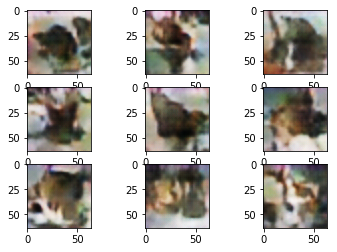

In [26]:
# - test against fake images
plt.figure()
for i in range(1,10):
    test_noise = torch.FloatTensor(1, nz, 1, 1).normal_(0,1)
    test_noisev = Variable(test_noise)
    if torch.cuda.is_available():
        test_noisev = test_noisev.cuda()
    test_fake_input = netG(test_noisev)
    test_fake_output = netD(test_fake_input)
    print('Fake image score: ' + str(test_fake_output.cpu().data.numpy()))
    plt.subplot(3, 3, i)
    plt.imshow(Unnormalize(test_fake_input.cpu().data.numpy()[0].transpose(1,2,0)))

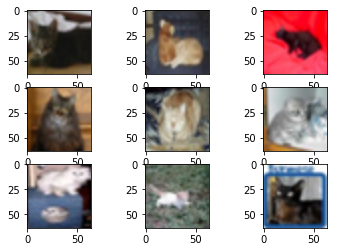

In [27]:
# compare against original images
test_dataloader = torch.utils.data.DataLoader(cat_dataset, batch_size=1,
                                              shuffle=False, num_workers=1)
test_data_iter = iter(test_dataloader)
for i in range(1,10):
    img = next(test_data_iter)
    plt.subplot(3, 3, i)
    plt.imshow(Unnormalize(img[0].numpy()[0].transpose(1,2,0)))

In [28]:
fixed_noise_input = netG(fixed_noise[0].unsqueeze(0))
fixed_noise_output = netD(fixed_noise_input)
print(fixed_noise_output)

Variable containing:
 0.8727
[torch.cuda.FloatTensor of size 1 (GPU 0)]



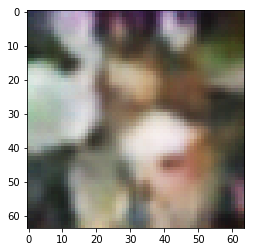

In [29]:
plt.imshow(Unnormalize(fixed_noise_input.cpu().data.numpy()[0].transpose(1,2,0)))